In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def coth(a):
    if a>0: return (1+tf.math.exp(-2*a))/(1-tf.math.exp(-2*a))
    if a<0: return (tf.math.exp(2*a)+1)/(tf.math.exp(2*a)-1)
    if a==0: return 0

def tanh(a):
    if a>0: return (1-tf.math.exp(-2*a))/(1+tf.math.exp(-2*a))
    if a<0: return (tf.math.exp(2*a)-1)/(tf.math.exp(2*a)+1)
    if a==0: return 0

In [3]:
data=10000
batch=100
set=100
layer=10
n_ini=1.0
n_fin=0.1
dn=-0.1
c_reg1=0.01
c_reg2=0.0001
d=3

m^2= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3004102836510247>
lam= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.15969606041567297>
alpha= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.15074073878945204>
beta= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.3027971392599651>
<tf.Variable 'Variable:0' shape=(10,) dtype=float64, numpy=
array([ 2.49677978,  1.50699608,  2.00788181,  2.75581497, -0.98912164,
        1.45218239,  1.61343932,  1.54233073,  0.78686413,  2.18047211])>


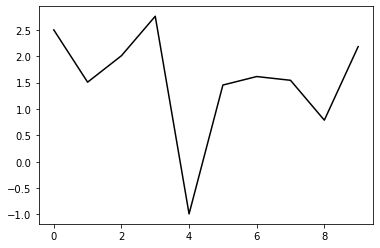

In [4]:
h=tf.zeros(layer)
h_in=[]
for i in range (layer):
    h_inn=np.float64(np.random.normal(2, 1))
    h_in.append(h_inn)
h=tf.Variable(h_in)
m2=tf.Variable(np.float64(np.random.normal(2, 1)))
lam=tf.Variable(np.float64(np.random.normal(1, 1)))
alpha=tf.Variable(np.float64(np.random.uniform(-0.5, 0.5)))
beta=tf.Variable(np.float64(np.random.uniform(-0.5, 0.5)))
#m2=tf.constant(np.float64(5.6))
#lam=tf.constant(np.float64(0.61))
#alpha=tf.constant(np.float64(1.444635))
#beta=tf.constant(np.float64(0.00615))
print("m^2=", m2)
print("lam=", lam)
print("alpha=", alpha)
print("beta=", beta)
print(h)
plt.plot(h.numpy(), 'k-')
plt.show()

In [5]:
def F_func(m, la, a,b):
    return 2*b/n_fin-m*a-la*(a**3)

def t_func(a):
    return 0.5*(tf.math.tanh(100*(a-0.1))-tf.math.tanh(100*(a+0.1))+2)

In [6]:
x=[i*0.2 for i in range (30)]
y=[0.0, 0.018, 0.035, 0.053, 0.0715, 0.0895, 0.107, 0.125, 0.146, 0.1665, 0.1875, 0.2085, 0.229, 0.25, 0.265, 0.281, 0.296, 0.3115, 0.3275, 0.343, 0.3565, 0.385, 0.4375, 0.5, 0.6, 0.675, 0.735, 0.815, 0.865, 0.885]
y[:]=[2*v for v in y]
fp1 = np.polyfit(x, y, 15)
print(fp1)

[ 1.59046394e-05 -6.81729682e-04  1.31412795e-02 -1.50525136e-01
  1.14052774e+00 -6.02241647e+00  2.27455168e+01 -6.20704699e+01
  1.22166922e+02 -1.71187074e+02  1.66428955e+02 -1.07461552e+02
  4.28229887e+01 -9.20544914e+00  9.55260239e-01 -1.30911492e-04]


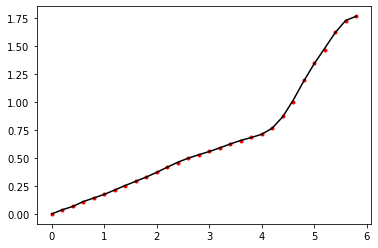

In [7]:
def f(x):
    y=0
    for i in range (16):
        y=y+fp1[i]*x**(15-i)
    return y
yy=[f(i*0.2) for i in range (30)]
plt.plot(x, y, 'r.')
plt.plot(x, yy, 'k-')
plt.show()

In [8]:
def NN_func_p(f):
    Positive=[]
    append=Positive.append
    while len(Positive)<batch:
        H=np.random.uniform(0.0, 6.0)
        M=np.random.uniform(0.0, 2.0)
        noise=np.abs(np.random.normal(0, 0.1))
        if np.abs(M-f(H))<=noise: append([H, M])
        else: continue
    return Positive
def NN_func_n(f):
    Negative=[]
    append=Negative.append
    while len(Negative)<batch:
        H=np.random.uniform(0.0, 6.0)
        M=np.random.uniform(0.0, 2.0)
        noise=np.abs(np.random.normal(0, 0.1))
        if np.abs(M-f(H))>noise: append([H, M])
        else: continue
    return Negative

In [9]:
Positive=[]
Negative=[]
for i in range (set):
    Positive.insert(i, NN_func_p(f))
    Negative.insert(i, NN_func_n(f))

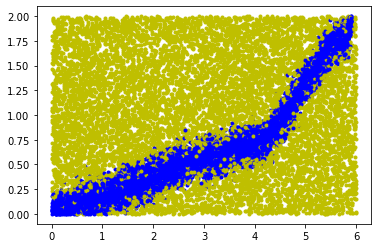

In [10]:
x_data1=[]
y_data1=[]
x_data2=[]
y_data2=[]
for i in range (set):
    x_data1.insert(i, [v[0] for v in Positive[i]])
    y_data1.insert(i, [v[1] for v in Positive[i]])
    x_data2.insert(i, [v[0] for v in Negative[i]])
    y_data2.insert(i, [v[1] for v in Negative[i]])
    plt.plot(x_data2[i], y_data2[i], 'y.')
    plt.plot(x_data1[i], y_data1[i], 'b.')
plt.show()

In [11]:
def Dfunc(hh, m):
    D=tf.math.sqrt(tf.math.abs(1+4*m/(hh[0]**2)))
    return D

In [12]:
def LP2(hh, m, la, alpha, beta, HH, MM):
    D=Dfunc(hh, m)
    phi=alpha*HH+beta*MM
    pi=(d/2)*(D-1)*alpha*HH+(d/2)*(-D-1)*beta*MM
    for j in range (layer-1):
        phi1=phi+dn*pi
        pi1 =phi*m*dn+(1-dn*hh[j])*pi+dn*la*(phi1**3)
        phi=phi1
        pi=pi1
    return phi, pi
def NN_func_01(hh, m, la, alpha, beta, list_hr):
    PP=[]
    NN=[]
    H=np.array(list_hr)[:, 0]
    M=np.array(list_hr)[:, 1]
    F=np.array(tf.math.abs(LP2(hh, m, la, alpha, beta, H, M)[1]))
    for i in range (len(H[F<0.1])):
        PP.append([H[F<0.1][i], M[F<0.1][i]])
    for i in range (len(H[F>=0.1])):
        NN.append([H[F>=0.1][i], M[F>=0.1][i]])
    return PP, NN

In [13]:
Positive0=[]
Positive1=[]
Negative0=[]
Negative1=[]
for i in range (set):
    Positive0.insert(i, NN_func_01(h, m2, lam, alpha, beta, Positive[i])[0])
    Positive1.insert(i, NN_func_01(h, m2, lam, alpha, beta, Positive[i])[1])
    Negative0.insert(i, NN_func_01(h, m2, lam, alpha, beta, Negative[i])[0])
    Negative1.insert(i, NN_func_01(h, m2, lam, alpha, beta, Negative[i])[1])

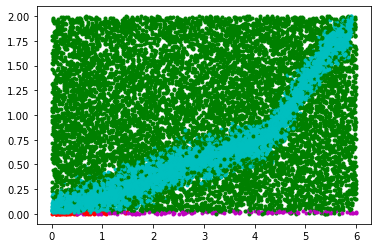

In [14]:
x_data1=[]
y_data1=[]
x_data2=[]
y_data2=[]
x_data3=[]
y_data3=[]
x_data4=[]
y_data4=[]
for i in range (set):
    x_data1.insert(i, [v[0] for v in Positive0[i]])
    y_data1.insert(i, [v[1] for v in Positive0[i]])
    x_data2.insert(i, [v[0] for v in Positive1[i]])
    y_data2.insert(i, [v[1] for v in Positive1[i]])
    x_data3.insert(i, [v[0] for v in Negative0[i]])
    y_data3.insert(i, [v[1] for v in Negative0[i]])
    x_data4.insert(i, [v[0] for v in Negative1[i]])
    y_data4.insert(i, [v[1] for v in Negative1[i]])
    plt.plot(x_data4[i], y_data4[i], 'g.')
    plt.plot(x_data2[i], y_data2[i], 'c.')
    plt.plot(x_data1[i], y_data1[i], 'r.')
    plt.plot(x_data3[i], y_data3[i], 'm.')
plt.show()

# Error function

$E=\sum_{data} \left\vert y(\bar{x}^{(1)}) - \bar{y} \right\vert+E_{reg}(W)$
, $E_{reg}=c_{reg}^{(1)}\sum_{n=1}^{N-1}(\eta^{(n)})^{4}(h(\eta^{(n+1)})-h(\eta^{(n)}))^{2}+c_{reg}^{(2)}(h(\eta^{(N)})-1/\eta^{(N)})^{2}$

In [15]:
def Error_func(hh, m, la, alpha, beta, list1, list2):
    H0=np.array([v[0] for v in list1])
    M0=np.array([v[1] for v in list1])
    H1=np.array([v[0] for v in list2])
    M1=np.array([v[1] for v in list2])
    H_0, M_0=LP2(hh, m, la, alpha, beta, H0, M0)
    H_1, M_1=LP2(hh, m, la, alpha, beta, H1, M1)
    PPlist=t_func(M_0)
    NNlist=t_func(M_1)
    sum_p=sum(PPlist)/batch
    sum_n=(batch-sum(NNlist))/batch

    inside=0
    for k in range (layer-1):
        second=((n_ini+k*dn)**4)*((hh[k+1]-hh[k])**2)
        inside=inside+second
    E_reg1=c_reg1*inside
    E_reg2=c_reg2*((hh[layer-1]-1/n_fin)**2)
    return sum_n+sum_p+E_reg1+E_reg2

In [16]:
for i in range (set):
    print(Error_func(h, m2, lam, alpha, beta, Positive[i], Negative[i]))

tf.Tensor(1.0813405033643786, shape=(), dtype=float64)
tf.Tensor(1.0413408787860294, shape=(), dtype=float64)
tf.Tensor(1.0514893198543427, shape=(), dtype=float64)
tf.Tensor(1.0726422860262104, shape=(), dtype=float64)
tf.Tensor(1.041733405216531, shape=(), dtype=float64)
tf.Tensor(1.0613030636273355, shape=(), dtype=float64)
tf.Tensor(1.0813192218256162, shape=(), dtype=float64)
tf.Tensor(1.0513949401238931, shape=(), dtype=float64)
tf.Tensor(1.1180356872285082, shape=(), dtype=float64)
tf.Tensor(1.0514000048215544, shape=(), dtype=float64)
tf.Tensor(1.0903336737371245, shape=(), dtype=float64)
tf.Tensor(1.0607980087201647, shape=(), dtype=float64)
tf.Tensor(1.0713376697470602, shape=(), dtype=float64)
tf.Tensor(1.0603904256848642, shape=(), dtype=float64)
tf.Tensor(1.0724144474120836, shape=(), dtype=float64)
tf.Tensor(1.0713972856565372, shape=(), dtype=float64)
tf.Tensor(1.0545792964544674, shape=(), dtype=float64)
tf.Tensor(1.0575796200970244, shape=(), dtype=float64)
tf.Tensor(1

# Optimize

0 1.066636279263193
2.30100107912269 0.15809445281159426 0.15158206766129134 0.3018481200373955
[ 2.44678128  1.55699496  1.95794824  2.7058162  -0.93912286  1.40218723
  1.56356347  1.4926722   0.8366875   2.23045261]


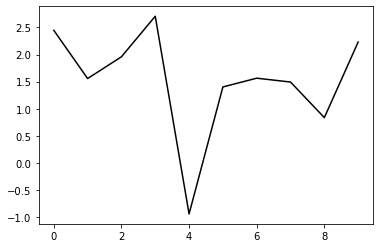

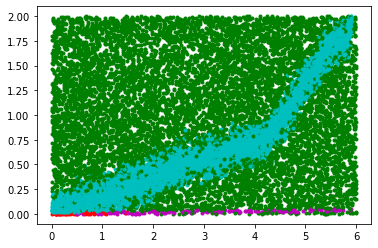

1000 1.017993156064921
2.3471827452946648 0.04753300662323293 0.30573308635297924 0.08432034401911875
[ 1.51997256  1.93654092  2.08126445  1.69891599  0.66263099  0.54910065
  0.64025645  0.0327486  -1.13935217  6.68902179]


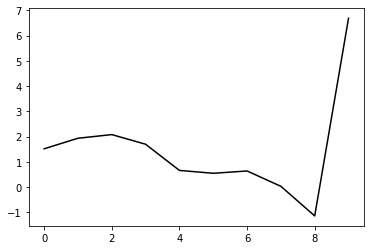

2000 0.34090455090405003
2.1672479850547277 0.017884159880427 0.24359823842281167 0.07252756373099817
[ 1.91706875  1.51953026  1.2888018   0.86525498  0.0670517  -0.50320855
 -0.88793134 -1.91868713 -3.7393005   8.10963291]


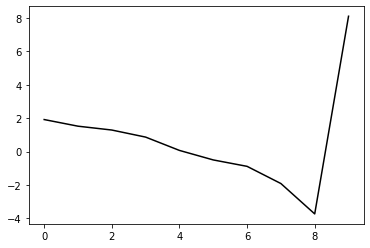

3000 0.33623241673592535
2.12321820265346 -0.11566800230768734 0.22438488449691946 0.07512011326528431
[ 1.89708258  1.64085065  1.32036855  0.8629375   0.16840397 -0.50693393
 -1.07026691 -2.21835259 -4.28688867  8.02995891]


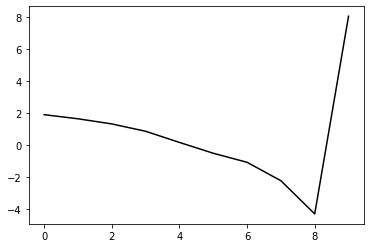

4000 0.21296345841623474
2.0180362984017823 -0.3750822840843331 0.26899239101070044 0.07646518073173078
[ 1.96513037  1.65574163  1.35127083  0.91711695  0.2888437  -0.41548016
 -1.09375733 -2.32667249 -4.56803411  7.98781243]


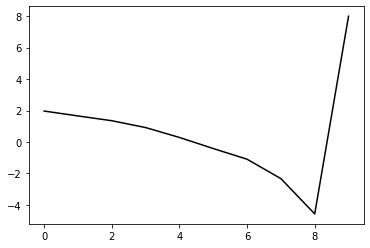

5000 0.17390841713761734
1.9428768362488622 -0.4245817886037407 0.2784540713687548 0.08587440538697706
[ 1.99604133  1.74429974  1.42622231  0.99876581  0.40728412 -0.30028074
 -1.04313004 -2.31499391 -4.66694941  8.02589657]


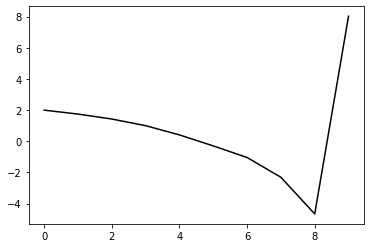

6000 0.23999345682629017
1.8765070923540377 -0.43644478902189604 0.272298761097663 0.09191573144105797
[ 1.92615667  1.84168473  1.54551622  1.11895585  0.53858751 -0.18536884
 -1.00815506 -2.34365407 -4.8050512   7.96006385]


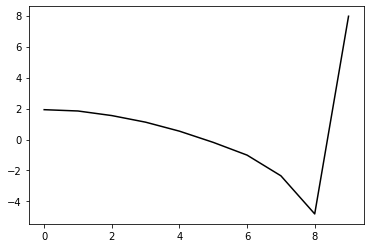

7000 0.29384037395138646
1.8039177729458187 -0.4491353048699977 0.26803760193601356 0.09625636132902309
[ 1.91339845  1.85241286  1.59999154  1.1908389   0.61579018 -0.12611575
 -1.02103935 -2.42705096 -5.00380092  7.92830383]


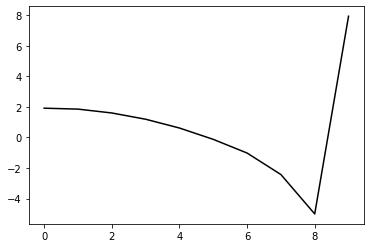

8000 0.1945296255065451
1.7549715272364406 -0.45439937376295353 0.2633046666565744 0.0993571094686495
[ 1.9585632   1.78994947  1.58214503  1.21020762  0.65397774 -0.09666971
 -1.05094599 -2.51650221 -5.16443674  7.97202615]


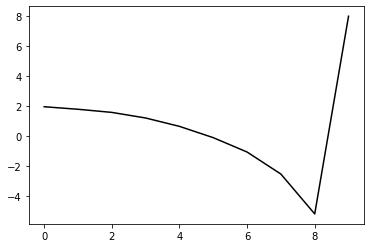

9000 0.20464042950381206
1.7031503681630162 -0.4612533793304536 0.2604085066278647 0.09969183348762495
[ 1.88626247  1.85122411  1.67015172  1.3286382   0.79334353  0.03776063
 -0.96657841 -2.4928349  -5.21344731  7.87759917]


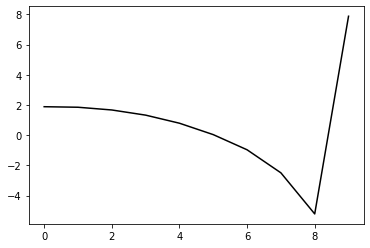

10000 0.23540516816622895
1.6696534610386282 -0.4621010511742676 0.25609518296032685 0.10086356100215459
[ 1.85688654  1.88317642  1.71602484  1.40835321  0.90668519  0.16245836
 -0.87559563 -2.45075301 -5.210346    7.8963792 ]


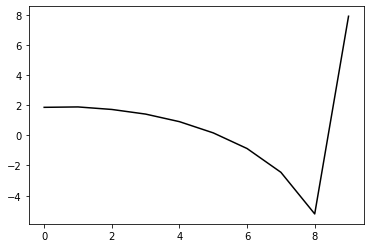

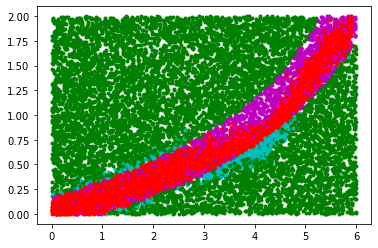

11000 0.2758248443193652
1.6335656835525203 -0.46312610825336964 0.25145244590116056 0.10250280676641396
[ 1.85363875  1.8771204   1.73164334  1.44764307  0.97201314  0.23956397
 -0.82598444 -2.45070557 -5.24336885  7.87918481]


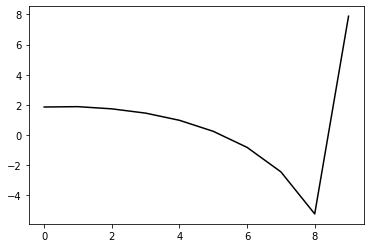

12000 0.19878032735244872
1.6024140902157507 -0.4642800585228968 0.24723786235955092 0.10694012440971665
[ 1.83573024  1.89636886  1.77896528  1.52309298  1.07751723  0.36510061
 -0.71431231 -2.38592003 -5.23068166  7.88208172]


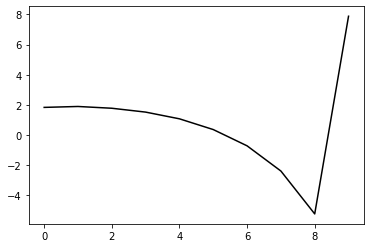

13000 0.2193709906918326
1.558371157221895 -0.46727395294648355 0.243824560095385 0.10586027794929224
[ 1.83552052  1.8620826   1.75054546  1.51350602  1.08839983  0.38752278
 -0.71098116 -2.44231006 -5.3662282   7.91280646]


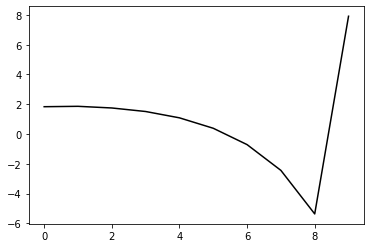

14000 0.2528279505540338
1.5214330167990477 -0.47215545983253615 0.24328088125090166 0.10727134666056258
[ 1.81253225  1.87249867  1.78686084  1.57004232  1.16795339  0.48553478
 -0.6202774  -2.40330725 -5.4087637   7.93248798]


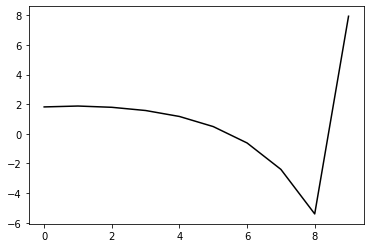

15000 0.20201132812426298
1.4996996506695643 -0.46555203046577165 0.236005486780793 0.1079987695973671
[ 1.81631724  1.84790211  1.77098837  1.57722884  1.20302566  0.5447118
 -0.55806696 -2.37646018 -5.4128252   7.89034862]


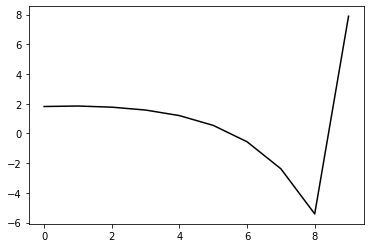

16000 0.17920587490210274
1.4689603710880372 -0.4656752184944348 0.23296265229692126 0.11042165995620448
[ 1.8301754   1.83262109  1.76357825  1.57818248  1.21726885  0.57198279
 -0.53441188 -2.39942955 -5.51999181  7.84889952]


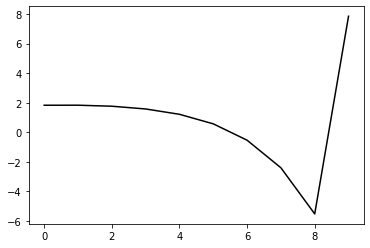

17000 0.180018239300679
1.4365197820303566 -0.4681328470678251 0.2318818175402038 0.10979710177254506
[ 1.79242166  1.8293355   1.76878049  1.60351269  1.26655741  0.64616848
 -0.44872833 -2.34464907 -5.52432129  7.85994024]


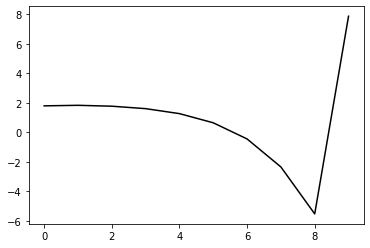

18000 0.22242429147269752
1.4047197024641027 -0.47287643700046644 0.23282404347735106 0.10887066312568405
[ 1.83076656  1.78974806  1.73809865  1.58736037  1.27551295  0.68547965
 -0.38904341 -2.30827282 -5.56827615  7.86577622]


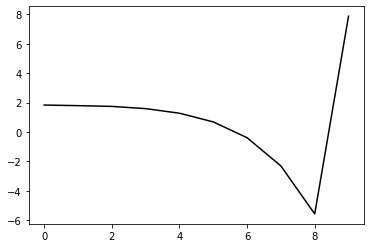

19000 0.16248751839572562
1.3891695849818366 -0.4658013614576208 0.22751103638541165 0.10849058160239698
[ 1.76960325  1.85048255  1.7991225   1.65486093  1.36050285  0.79771943
 -0.25056418 -2.17226842 -5.4681846   7.88514937]


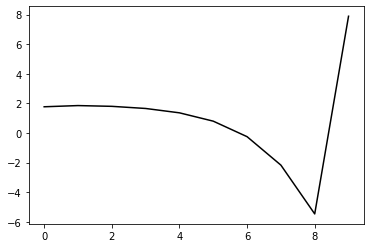

20000 0.21482911728653695
1.3640167410943664 -0.4654768511972925 0.2266084750516229 0.10865818524873576
[ 1.78705055  1.85410759  1.79723167  1.65569479  1.37348061  0.83140853
 -0.19521983 -2.12080115 -5.45653017  7.88328409]


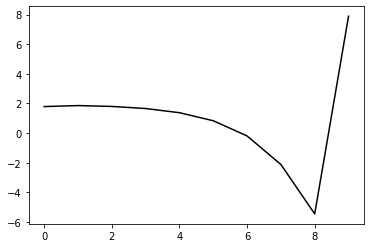

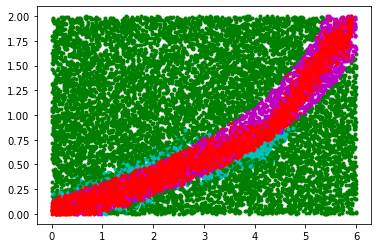

21000 0.19278590099495874
1.3369007062571896 -0.4633527013889827 0.223811891284066 0.10753780198372212
[ 1.77638687  1.84480248  1.7998491   1.67011112  1.39858585  0.87201427
 -0.13814572 -2.07239499 -5.47333045  7.8733589 ]


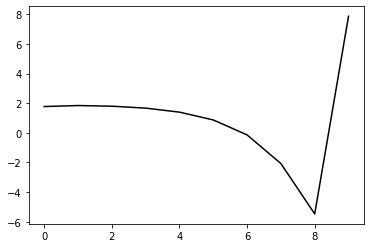

22000 0.26273118680258706
1.3127449924415722 -0.4615562582631561 0.22230388788961067 0.10828048845113515
[ 1.79827696  1.83218324  1.80035019  1.68172701  1.42662672  0.92271909
 -0.06226944 -1.99363631 -5.44592398  7.90455483]


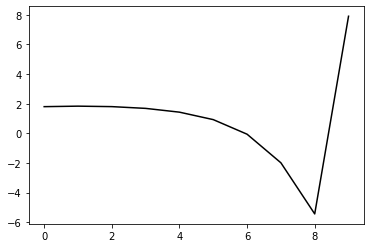

23000 0.1655173396265716
1.2808141686463912 -0.4620935966459765 0.21976632458013035 0.10960979184798213
[ 1.76380162  1.8420759   1.81741302  1.70257971  1.44715075  0.94263177
 -0.04442692 -2.00001143 -5.53815913  7.87515747]


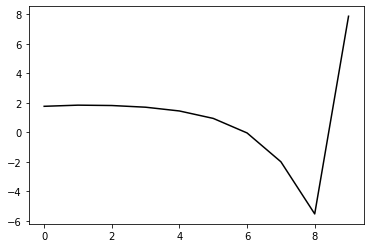

24000 0.24394318530630066
1.2534971302932134 -0.45886088502488115 0.21789416853560317 0.10675911918805892
[ 1.75445449  1.85183849  1.8252035   1.72212504  1.48763776  1.00785147
  0.04901924 -1.88612581 -5.44642567  7.9110068 ]


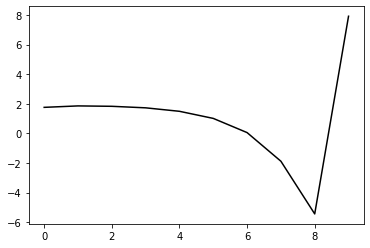

25000 0.27757159088999944
1.2198006488767326 -0.45924191876509857 0.21642524854236073 0.1064600847502246
[ 1.74593429  1.84393809  1.82275256  1.72543411  1.50008887  1.03408641
  0.08999046 -1.84169346 -5.44103917  7.88725021]


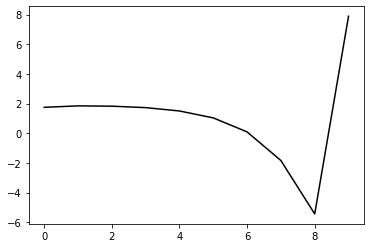

26000 0.19303072943298152
1.1894312071525022 -0.4564506406953333 0.2147678352747554 0.10443400457207355
[ 1.75866795  1.8160603   1.78425557  1.69146023  1.47970029  1.03450646
  0.11688554 -1.79377271 -5.41439568  7.87053113]


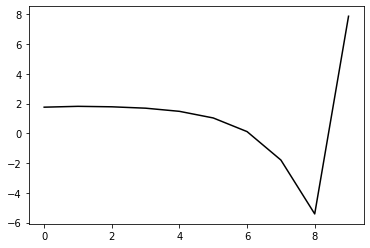

27000 0.185495492165136
1.1606932341737723 -0.4538788038010155 0.2134383080879065 0.10272566094165063
[ 1.74230448  1.81900645  1.79215666  1.69847637  1.48967743  1.05658471
  0.15779129 -1.74009972 -5.40065418  7.90519046]


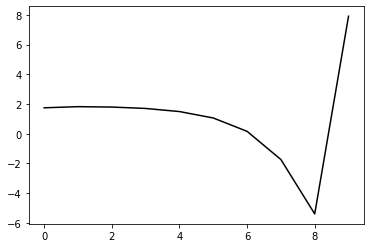

28000 0.1590063465662082
1.1380951903375809 -0.44955368208144336 0.21148332469968412 0.10246854420900603
[ 1.79358973  1.75027626  1.73754235  1.64770829  1.43930836  1.00928187
  0.11856782 -1.77540742 -5.46721777  7.88710322]


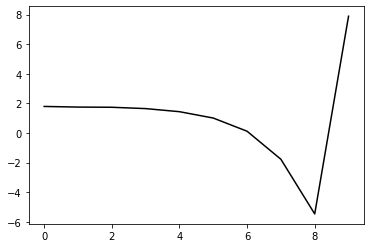

29000 0.1984886383744413
1.1068042896911507 -0.44702568927320624 0.2078520337593666 0.1039604497155941
[ 1.72900064  1.79779916  1.77977763  1.69068151  1.48026855  1.04655858
  0.15393903 -1.74791834 -5.50474889  7.85779607]


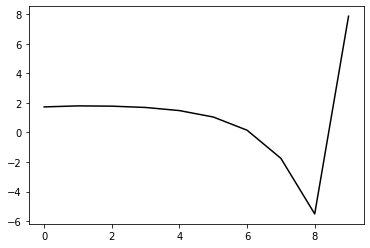

30000 0.22620649993199352
1.0802834170849407 -0.4449519067309223 0.20725546625732227 0.1027093017504611
[ 1.75174575  1.77467236  1.76088682  1.6884269   1.50307842  1.10024241
  0.24597777 -1.61088706 -5.36334282  7.89300409]


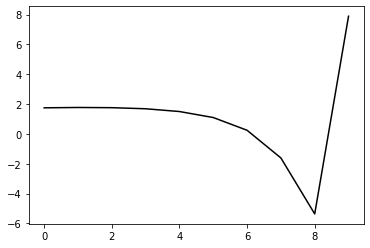

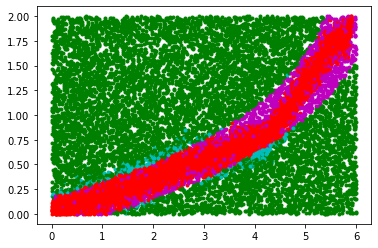

31000 0.2417316290469558
1.054219895199056 -0.445386320522755 0.20838714938781275 0.10287739361496236
[ 1.72601192  1.79770198  1.79047872  1.72458168  1.556295    1.18291091
  0.36809664 -1.4406472  -5.15643723  7.91723974]


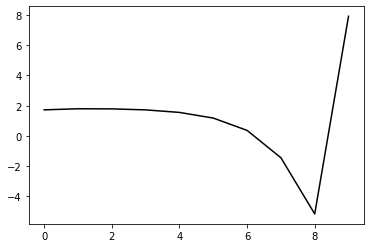

32000 0.21518750506623355
1.0218293833859255 -0.4399178705524192 0.20526905047574237 0.10179430713080356
[ 1.73912512  1.77763474  1.74814756  1.67297973  1.50165448  1.13109274
  0.32606347 -1.4686795  -5.18319269  7.85765154]


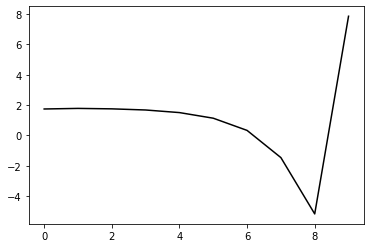

33000 0.17817338155216797
0.9885912179630494 -0.4376324562923212 0.20612493598052647 0.09984307071181527
[ 1.72599711  1.80331638  1.78147328  1.71089151  1.54653747  1.18947051
  0.40604457 -1.3625454  -5.06524354  7.95128108]


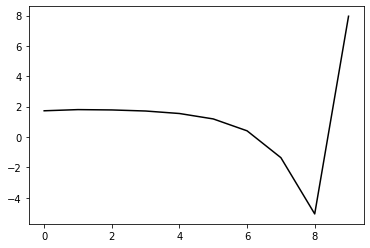

34000 0.293658008674051
0.963696992206575 -0.4317065481450732 0.2043412943910928 0.09693794415489104
[ 1.7057828   1.81058857  1.7969837   1.73850898  1.58701017  1.24638706
  0.48814313 -1.24852892 -4.94126447  7.95600146]


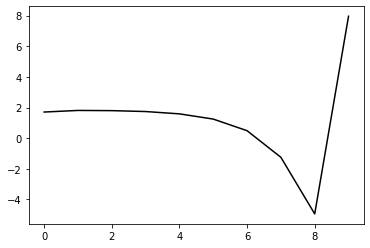

35000 0.24823693448105028
0.9216546304609181 -0.43340024077990585 0.20527621982674263 0.09481513924292098
[ 1.72959656  1.77961258  1.76764216  1.69667124  1.53558859  1.19132989
  0.43516323 -1.29411191 -4.99646836  7.93454708]


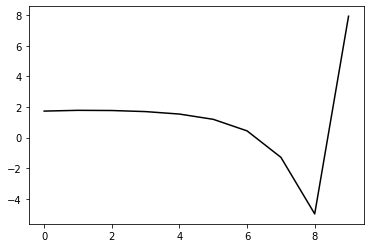

36000 0.25975013169294786
0.9074549194353713 -0.4152427695715847 0.19552666775185876 0.09891204236932365
[ 1.72620525  1.81765691  1.81292868  1.74911116  1.59764181  1.26722312
  0.53456293 -1.16020599 -4.83876635  7.98071089]


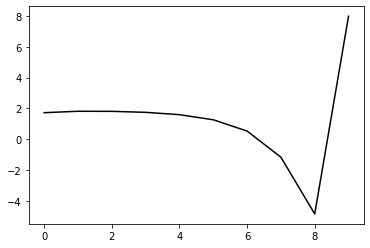

37000 0.30388742823763726
0.8721132980401295 -0.41880210826459624 0.20015692283789727 0.09396816596401165
[ 1.70014714  1.80132537  1.79733447  1.74434324  1.60029193  1.27411803
  0.54816299 -1.13092768 -4.79860048  7.9308021 ]


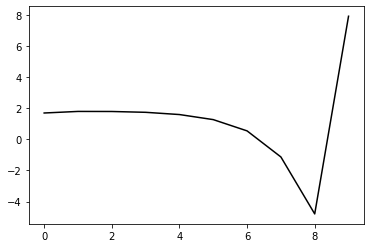

38000 0.1783736411893109
0.847012797941123 -0.4150732022626696 0.1993858166416093 0.09538760183928655
[ 1.74305142  1.7796836   1.77458337  1.72365821  1.58480651  1.26595287
  0.5497358  -1.10943588 -4.74330477  7.98915629]


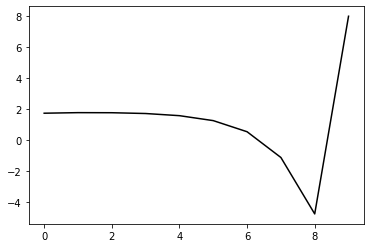

39000 0.16856591089003667
0.8264049613296977 -0.40617909251220846 0.19629574163771174 0.09320535344800805
[ 1.69906981  1.8141103   1.80911658  1.75223742  1.6064946   1.28139252
  0.55913768 -1.10557173 -4.75386973  8.00295128]


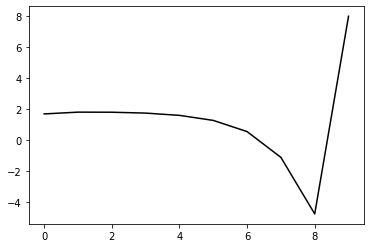

40000 0.2093725912846454
0.7920547748151114 -0.4029350741688665 0.19481121767630216 0.09414271717669202
[ 1.72214573  1.78466856  1.77432141  1.71892647  1.58171581  1.27171867
  0.57251777 -1.05915917 -4.66893649  7.96323935]


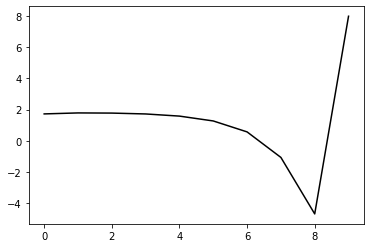

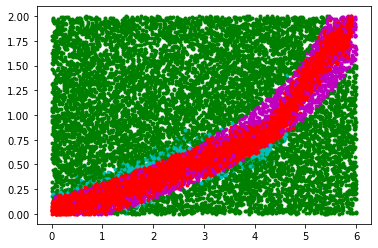

41000 0.18154329075744768
0.7710155864212906 -0.39802272213994033 0.19394160290143747 0.09256427277074622
[ 1.68472703  1.80320692  1.8223122   1.7843509   1.65755874  1.35753397
  0.6730623  -0.93709144 -4.52414082  8.01038065]


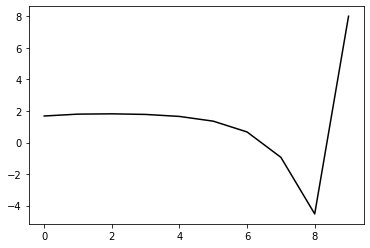

42000 0.22505074936727926
0.7518235982745995 -0.3915914256675467 0.19276983688943855 0.09033324042943561
[ 1.70150033  1.78299459  1.78542608  1.74022789  1.62233895  1.34286332
  0.68832114 -0.87802398 -4.40399553  8.03490926]


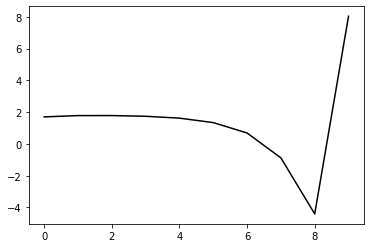

43000 0.19279833146475808
0.7272863336353597 -0.39281308899730905 0.19599305298739014 0.08975370805903954
[ 1.70433422  1.78097347  1.77888283  1.73766395  1.6193624   1.33908703
  0.69447892 -0.83973    -4.30146067  8.01184069]


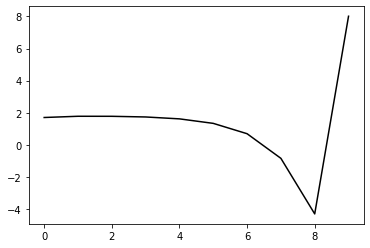

44000 0.22491350390928608
0.7037875932120279 -0.3855183982197223 0.19249567805540801 0.09054111494560688
[ 1.68801856  1.73191791  1.72915813  1.68031015  1.54695603  1.25285202
  0.60016516 -0.92691444 -4.35235119  8.06791992]


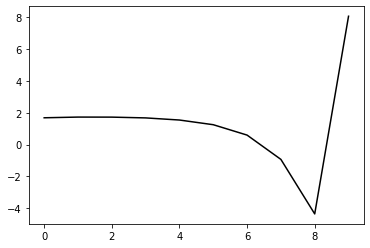

45000 0.2783662747472015
0.6913168635249834 -0.38077744685839227 0.19165465909053853 0.09263520268557418
[ 1.6406288   1.80476353  1.80772633  1.7495553   1.6110059   1.31764378
  0.67816075 -0.81192834 -4.1583881   8.0167791 ]


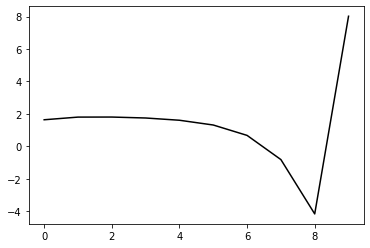

46000 0.2408284843579842
0.6584816444834518 -0.37817237672211407 0.18954880741994767 0.09423135476606813
[ 1.67169443  1.7058768   1.7095375   1.65166519  1.51197941  1.21322337
  0.56849407 -0.91228083 -4.21310314  8.05291662]


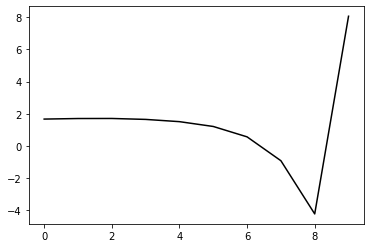

47000 0.24252098302474176
0.6416414506408961 -0.374422713947409 0.1903786809330507 0.0926426809148998
[ 1.66136804  1.67924595  1.68787345  1.64499647  1.52119579  1.23490575
  0.59795754 -0.87063162 -4.13245884  8.06764392]


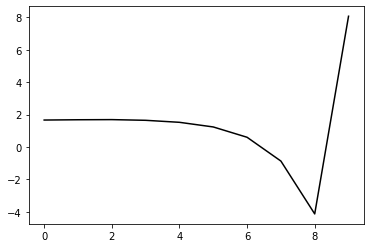

48000 0.23128474514804132
0.622920672205194 -0.37239008638958326 0.18989890637902382 0.09280262807173204
[ 1.62186457  1.66547495  1.66446469  1.61348082  1.48054503  1.18700588
  0.54458102 -0.91995426 -4.13690234  8.04661244]


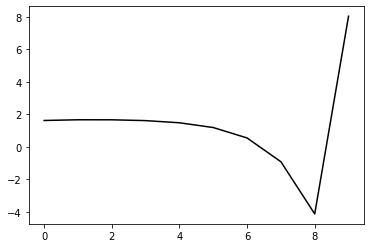

49000 0.14619613176028376
0.6039436775300125 -0.3690952709861665 0.19125180509059525 0.09282384059846623
[ 1.62928623  1.69374166  1.68851657  1.64453312  1.53598463  1.27799531
  0.67384774 -0.75428786 -3.91792732  8.08637139]


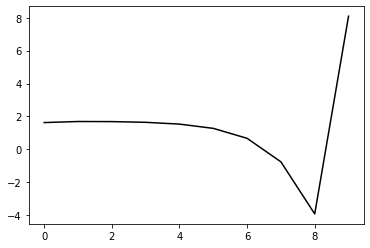

50000 0.15439778126986203
0.5955613359319565 -0.3616694432598093 0.19004837938463712 0.09058071943775581
[ 1.62231299  1.65788153  1.64433414  1.59820807  1.48093841  1.21450554
  0.61635095 -0.78480987 -3.87588648  8.08810704]


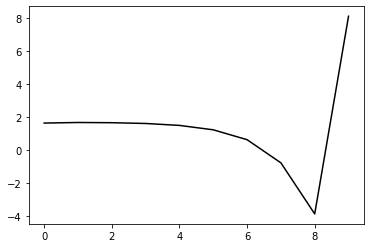

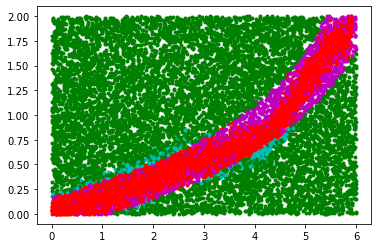

51000 0.19497069088897706
0.575895061793093 -0.36000710452382173 0.19120022890520263 0.09074525869751499
[ 1.60547145  1.67430176  1.67520011  1.6332904   1.5189151   1.26039874
  0.67302892 -0.70945548 -3.75554572  8.13170069]


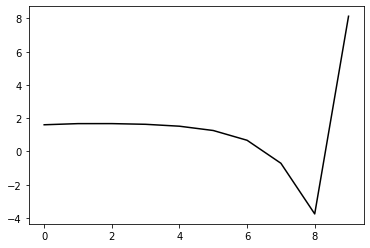

52000 0.18951399054008577
0.5564102200339245 -0.3577148902468589 0.1914514344214213 0.09070748178854043
[ 1.62728129  1.64300135  1.6209346   1.5632308   1.43470978  1.16332412
  0.57339783 -0.78848896 -3.76198998  8.11285457]


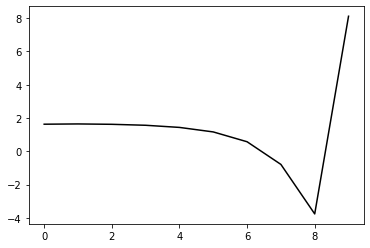

53000 0.24904285812488283
0.5553001754649532 -0.3462443847006023 0.18728530568725357 0.09227520814685988
[ 1.56699998  1.66337519  1.67306508  1.61499512  1.47092574  1.181819
  0.5810445  -0.77220509 -3.69395747  8.16438313]


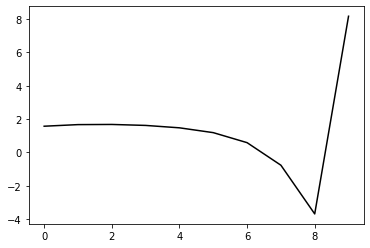

54000 0.17715657589012251
0.5375317063835858 -0.3530420017104003 0.1919217444865916 0.09775939372022212
[ 1.60152182  1.64839896  1.64525015  1.58583754  1.45105295  1.17227812
  0.58272137 -0.74258228 -3.58805497  8.15777751]


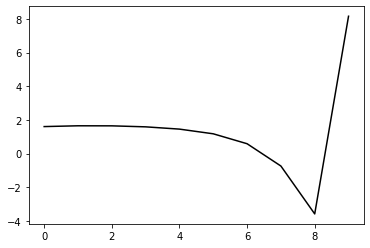

55000 0.16962968775259624
0.53577346979588 -0.3470073885121518 0.19194028345367103 0.09601811200299898
[ 1.56632699  1.61077199  1.61046235  1.56473516  1.44298012  1.17011497
  0.58101768 -0.7360252  -3.53320823  8.12014931]


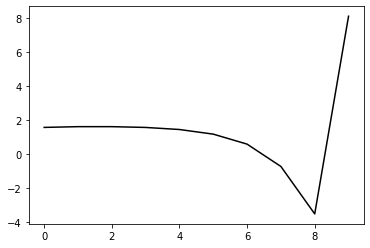

56000 0.15913231707786557
0.5160712973552245 -0.3473531253789163 0.19360474128080724 0.09254348224933658
[ 1.55820033  1.54377909  1.51971807  1.47157791  1.35816626  1.10343143
  0.53320419 -0.76836218 -3.52232235  8.13735292]


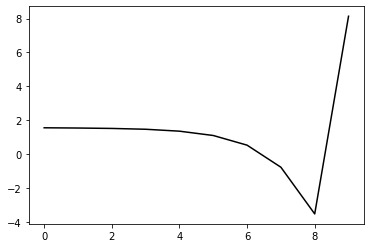

57000 0.1840549412373228
0.5141891989320801 -0.3399922112830133 0.19184619351884927 0.09530241219779072
[ 1.55311148  1.58857943  1.5654849   1.49633206  1.35549048  1.08577581
  0.52159821 -0.75521594 -3.44192593  8.14813843]


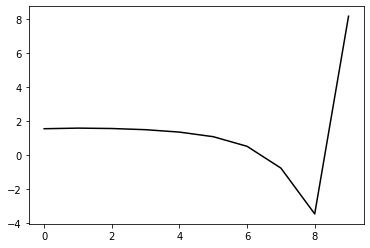

58000 0.22942324636440314
0.49656232145507306 -0.3417575187354579 0.19534639401677995 0.09468117241158767
[ 1.56119717  1.54115157  1.52200383  1.4651838   1.33331402  1.06431759
  0.50065115 -0.76318424 -3.40579207  8.16202387]


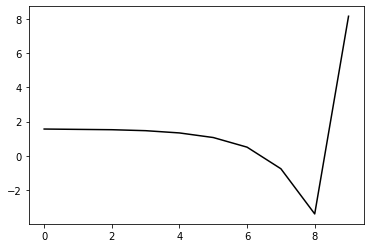

59000 0.18033746425605138
0.4909625101100359 -0.32931295534416855 0.18951057543249564 0.09424633405990251
[ 1.57232764  1.44578681  1.45296871  1.39243268  1.24729642  0.95998576
  0.37647566 -0.89764128 -3.51885292  8.12237249]


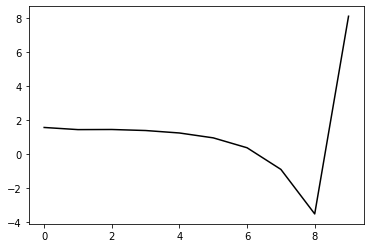

60000 0.25954617957876674
0.4814928604654161 -0.32904235282422944 0.19104301119639408 0.09831788010759654
[ 1.5045197   1.56781533  1.56430257  1.50227006  1.36357887  1.08068427
  0.49573214 -0.776754   -3.37000738  8.13804104]


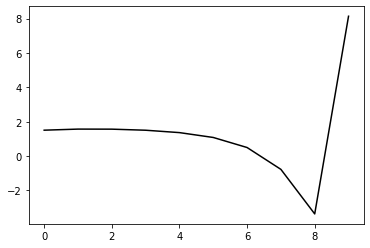

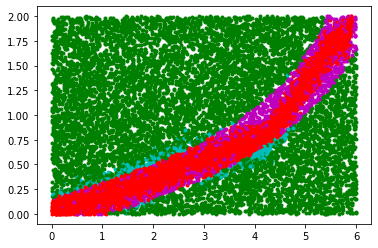

61000 0.20441165256183869
0.46513598107682913 -0.32777608867771335 0.1917404615018105 0.09882411365544634
[ 1.52814534  1.51534919  1.50109139  1.4337133   1.30084047  1.03403139
  0.46583331 -0.78884637 -3.33695104  8.16481253]


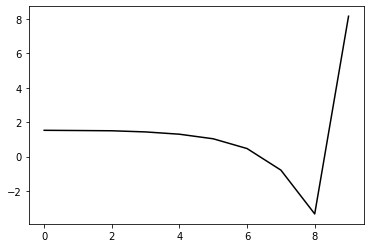

62000 0.19207052092119004
0.47126373033651303 -0.31699751176605695 0.19095757302699284 0.09342181863688369
[ 1.4939372   1.55250468  1.53426851  1.46399047  1.32474967  1.05651393
  0.49688144 -0.74336976 -3.25452559  8.19825697]


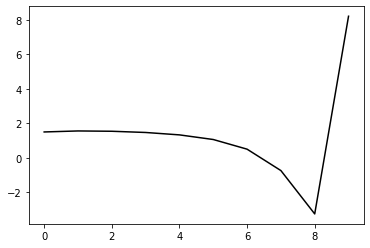

63000 0.1638252747774239
0.46297929476127564 -0.3134769560574977 0.1914688692676658 0.09444294411821785
[ 1.50016337  1.56614717  1.5477247   1.47295683  1.32934903  1.05103499
  0.48313605 -0.75209986 -3.22447341  8.17375368]


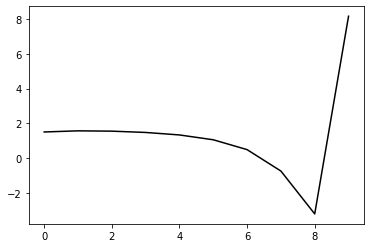

64000 0.2607528185711425
0.4569925892317358 -0.31129905527943846 0.19301484892613072 0.09311620690340844
[ 1.44950862  1.53777086  1.51512171  1.43859304  1.28439959  0.99912198
  0.43268576 -0.78773259 -3.21279696  8.191432  ]


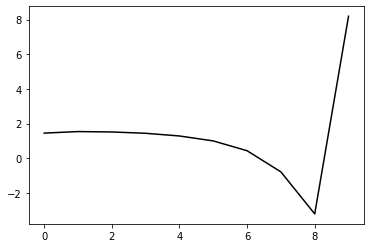

65000 0.23522665797709677
0.4500071868184515 -0.3071998680219393 0.19135107818519728 0.09415925428610597
[ 1.46322995  1.53277768  1.5134569   1.44668907  1.30563364  1.02573776
  0.46441183 -0.73539452 -3.09917279  8.20292176]


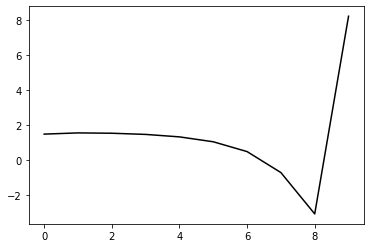

66000 0.19930867240654573
0.4431928025517756 -0.3058961417539959 0.1925016405871178 0.09631051897937347
[ 1.48007176  1.54396999  1.52290522  1.44817257  1.31058773  1.04119517
  0.49100016 -0.68565572 -2.98195178  8.21464826]


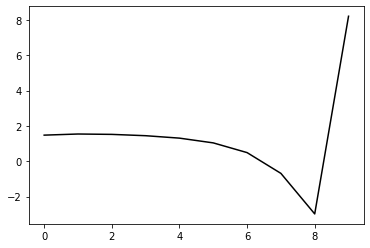

67000 0.21084731246777466
0.4327657918600842 -0.3067494171703504 0.19525300128568554 0.09537147769818997
[ 1.47777204  1.48226687  1.44261669  1.37159234  1.23239415  0.96245585
  0.41931595 -0.74026198 -2.98248215  8.21580125]


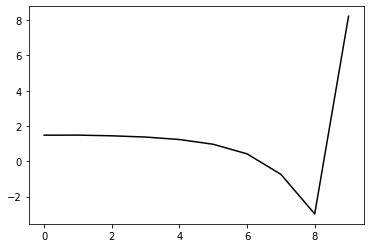

68000 0.19660704123987985
0.43136522721852905 -0.2993223652140561 0.19345188874008723 0.09502998389641848
[ 1.45775307  1.54243302  1.52949805  1.43922061  1.27373369  0.9826796
  0.4230252  -0.74440685 -2.96331023  8.19314488]


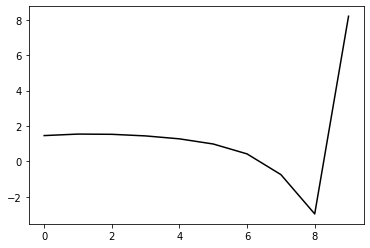

69000 0.15086435916225266
0.4213616602843475 -0.29649954255172933 0.19278554398597617 0.09482323221534943
[ 1.45839182  1.50350959  1.4890198   1.41786639  1.26994032  0.98160671
  0.41533583 -0.75222892 -2.93939727  8.240189  ]


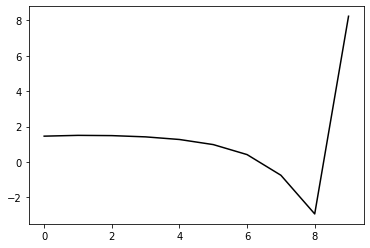

70000 0.20737217213510095
0.41567940099361017 -0.2952595671520632 0.19428138864359076 0.09650222008786785
[ 1.5036874   1.45016557  1.41848014  1.33921001  1.19329273  0.91728365
  0.36840856 -0.77196784 -2.89030078  8.2294835 ]


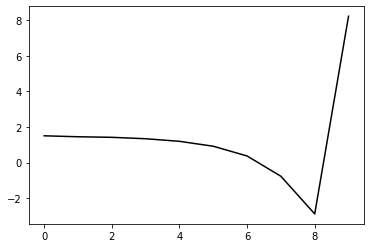

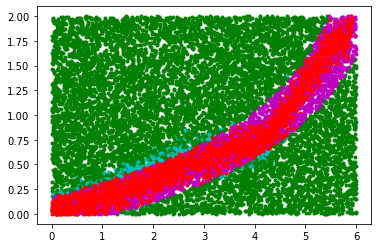

71000 0.24481879212473476
0.4018888283475442 -0.29441051362689485 0.19569316915925117 0.09764699506812412
[ 1.49855941  1.43838855  1.36088622  1.26548427  1.11399188  0.84303269
  0.30707301 -0.81585557 -2.89309973  8.24861409]


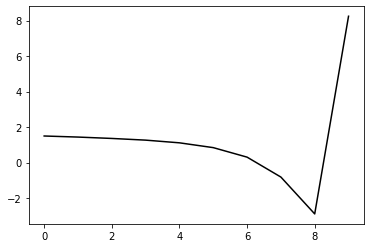

72000 0.1788831298107953
0.4040331274032791 -0.287047578603805 0.19495565552681696 0.09555577630739323
[ 1.47633807  1.48973428  1.46706141  1.39574452  1.25185127  0.97747346
  0.44008393 -0.67935778 -2.73540851  8.29342621]


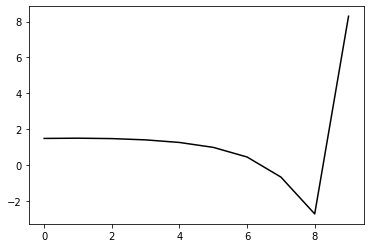

73000 0.1678440051946472
0.39366980925323697 -0.29105165480997486 0.1989404011265186 0.09862679626572635
[ 1.46204632  1.47321331  1.44420334  1.35925631  1.2039208   0.9243809
  0.38537564 -0.72449189 -2.73822935  8.23953932]


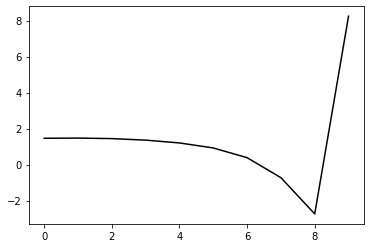

74000 0.22290561263908917
0.3910095920271961 -0.28308251062314543 0.1969506736578928 0.09877960939860586
[ 1.47703303  1.48341519  1.4514449   1.3651352   1.21246748  0.93374262
  0.39485659 -0.71043091 -2.69966338  8.23584269]


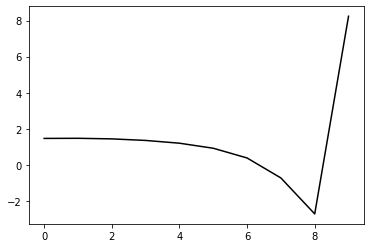

75000 0.10581988770337726
0.38573943116162285 -0.2810413519162287 0.19730791676326334 0.09831196565395807
[ 1.43488916  1.42749042  1.36832826  1.27724927  1.12598505  0.85008995
  0.31722094 -0.7728566  -2.71896334  8.2326869 ]


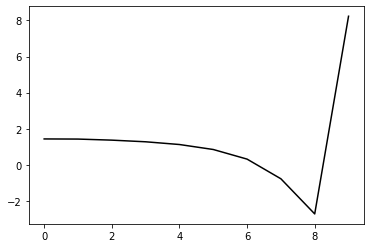

76000 0.20019003635540103
0.3839614888248952 -0.27716147997349017 0.1978461278388059 0.10132406519015358
[ 1.41871993  1.47707022  1.44146178  1.34055775  1.17050339  0.88008012
  0.34186659 -0.74075488 -2.64937145  8.26152934]


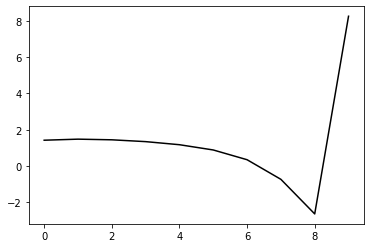

77000 0.25617592594590083
0.379902953865336 -0.27215034174123487 0.19697357725525907 0.09766288829252594
[ 1.3973326   1.41645933  1.34001359  1.22789163  1.05616128  0.76101542
  0.21489968 -0.86672633 -2.74475785  8.22943377]


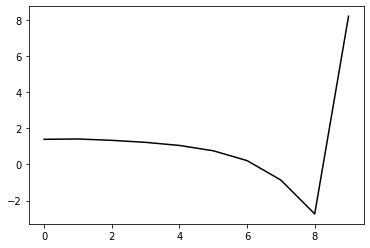

78000 0.3098279953983059
0.3759810382849043 -0.26973272829892964 0.1990130175427529 0.09870098529375894
[ 1.39152163  1.43292241  1.38897734  1.30450629  1.15101433  0.86486953
  0.322179   -0.75508087 -2.60717025  8.28501902]


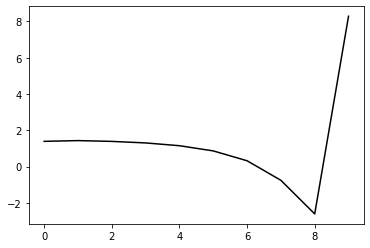

79000 0.27046690456677336
0.37375992983238926 -0.26769057059081247 0.19982474485857687 0.09927800141533394
[ 1.41356749  1.43194499  1.32901158  1.22310434  1.07024458  0.80312399
  0.28801235 -0.75507058 -2.5437846   8.28115033]


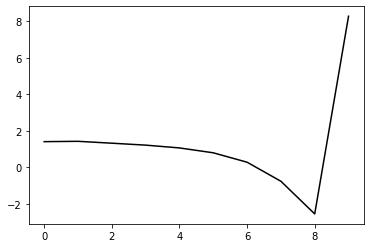

80000 0.2504730574790776
0.36873001399212263 -0.263774870361023 0.20008078511512511 0.09898828106864006
[ 1.4020557   1.41925898  1.38622792  1.29143099  1.12814314  0.85321798
  0.34172011 -0.69273622 -2.45935073  8.28745524]


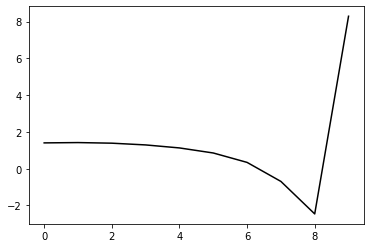

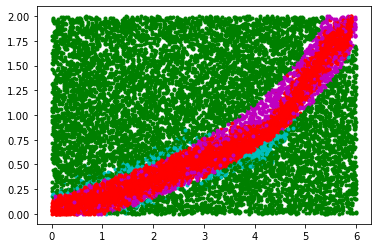

81000 0.18544607180824207
0.3649444275358752 -0.26123791084472997 0.2004792072009136 0.09801457312731034
[ 1.41572057  1.40983497  1.35364996  1.2540275   1.09704463  0.81970304
  0.30353056 -0.72458604 -2.46428545  8.29270417]


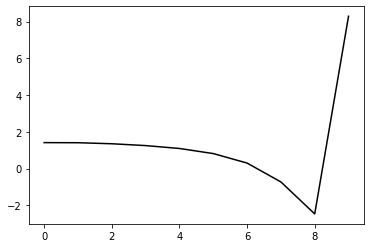

82000 0.2639408410254562
0.3582166402904675 -0.2541569956156335 0.19755623387744858 0.09585845921720043
[ 1.40374672  1.37719365  1.31689511  1.19989658  1.01646926  0.72487885
  0.20074489 -0.82987935 -2.55525955  8.27637002]


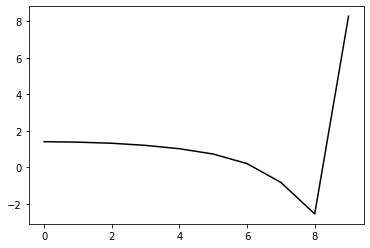

83000 0.12014117550043038
0.3565696031783926 -0.25505599831448833 0.20062983929321795 0.10160161671996207
[ 1.40868193  1.43152208  1.40940838  1.31147462  1.13267346  0.82623614
  0.28094568 -0.75773581 -2.46084368  8.2839068 ]


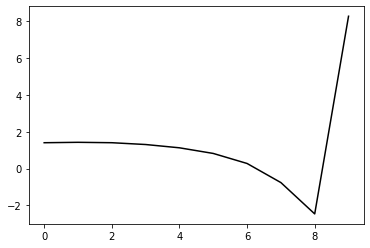

84000 0.2121781724370651
0.35110157035623996 -0.2513176846250089 0.19949181530236748 0.10100311693988757
[ 1.39200578  1.39267742  1.3415359   1.2363504   1.05907532  0.75082536
  0.19487897 -0.85461687 -2.54890401  8.27830605]


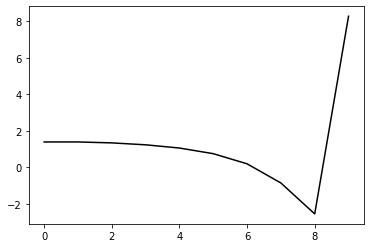

85000 0.238401797283528
0.33931873731961043 -0.2604072271997621 0.20683946232102257 0.0985787994852555
[ 1.38795325  1.31260915  1.22751955  1.12866936  0.9762546   0.70714874
  0.19032969 -0.82625643 -2.4657614   8.31443021]


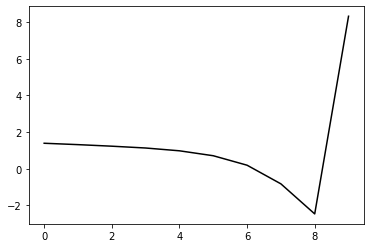

86000 0.16828877858523586
0.3370338553343253 -0.25964756278373285 0.20775582876270135 0.098935082256281
[ 1.38930331  1.32379761  1.25663357  1.15665632  0.9921304   0.70375038
  0.17394864 -0.84747714 -2.4683566   8.29964277]


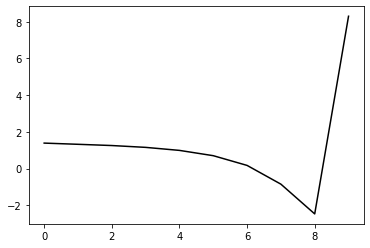

87000 0.17693441337583357
0.3453416688841124 -0.24450281986047115 0.20230533112390622 0.09930401031994884
[ 1.3862919   1.43055582  1.35118714  1.22721116  1.04800987  0.75145478
  0.21336939 -0.81834514 -2.44192285  8.30032791]


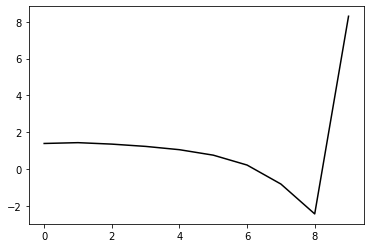

88000 0.23411601278916516
0.3462756143365772 -0.2393328788381241 0.20081313596727748 0.10033235682869542
[ 1.36925345  1.43089073  1.40581451  1.30933687  1.13163714  0.82169366
  0.2697576  -0.767149   -2.37451621  8.26997942]


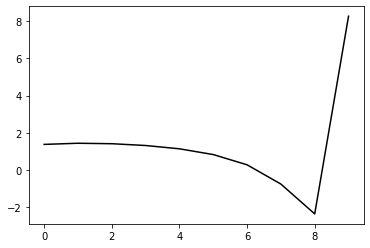

89000 0.25944482765600013
0.33698034283243583 -0.2413739010729943 0.2028270384520365 0.10066299934412233
[ 1.40884271  1.37709141  1.34486845  1.25054946  1.08218596  0.78149061
  0.22904719 -0.80905715 -2.40056521  8.29575912]


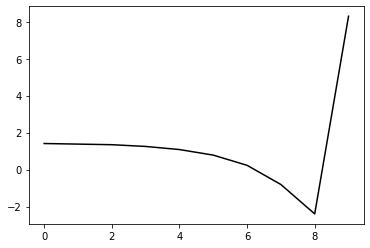

90000 0.27405640827349
0.3273396870367893 -0.24486161999629588 0.2049233311543437 0.10306098704630011
[ 1.34936655  1.34139236  1.29889285  1.21671627  1.05689871  0.75878548
  0.20509392 -0.83685815 -2.41853969  8.28263386]


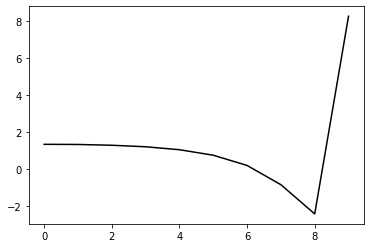

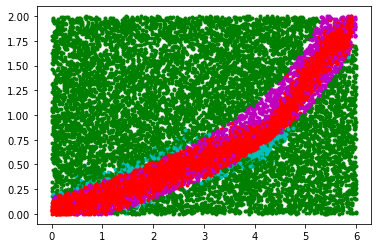

91000 0.23853784992901403
0.32972312921593877 -0.23799612261386813 0.20403748677044697 0.10045997150245099
[ 1.33343409  1.35102411  1.30530965  1.2197543   1.06621645  0.78711071
  0.25598042 -0.77019025 -2.32666698  8.28570708]


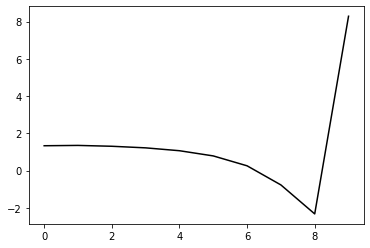

92000 0.23527858021398332
0.3215238313551278 -0.24253762022736897 0.20733297151323782 0.10323912365578737
[ 1.37243952  1.37534626  1.30618896  1.19520835  1.02306803  0.73673037
  0.2103913  -0.80463979 -2.33662139  8.28957639]


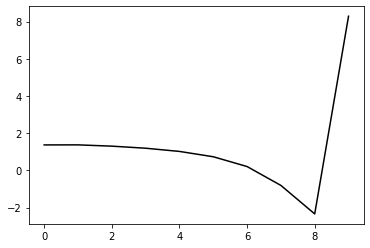

93000 0.15628760111716994
0.32564816987812845 -0.23260109016679312 0.2035158566377696 0.10062740497406812
[ 1.35072253  1.3591403   1.31915207  1.22257708  1.04707876  0.74322818
  0.19915594 -0.82541612 -2.35730635  8.30631217]


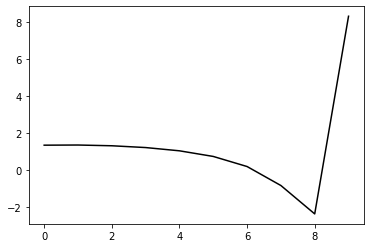

94000 0.20313515254047795
0.32149499141901605 -0.23133075135465925 0.2036206295720706 0.1015980030135022
[ 1.36439759  1.31193024  1.24109568  1.14362945  0.97903937  0.68612249
  0.14759884 -0.86810572 -2.37836869  8.29250727]


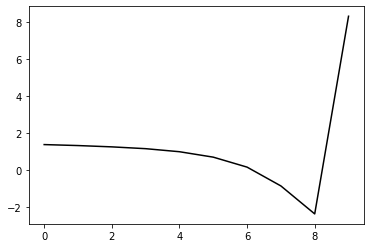

95000 0.13015202856908326
0.3245293808411299 -0.22762227472728547 0.20370455703337112 0.1026816318334784
[ 1.34548928  1.37040242  1.32368873  1.20989268  1.02661997  0.72169092
  0.17675001 -0.83953695 -2.33351838  8.29550179]


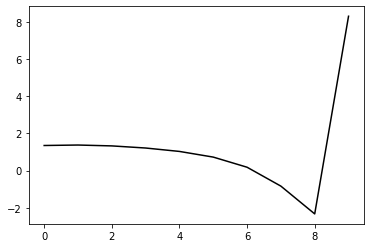

96000 0.18183843511032435
0.3199553000179355 -0.23205486055445043 0.208883491816164 0.10177814329734602
[ 1.37007674  1.35988226  1.30385519  1.20463473  1.03757271  0.7475716
  0.21586621 -0.78525211 -2.25219402  8.29282071]


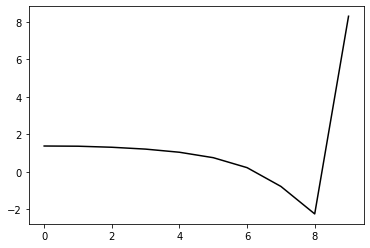

97000 0.16352340452389855
0.3087613297484056 -0.2322154226670228 0.2087129533817216 0.1048224881730179
[ 1.43531752  1.29346364  1.17732486  1.07253628  0.90596379  0.62311656
  0.10811621 -0.8707735  -2.30319703  8.34131436]


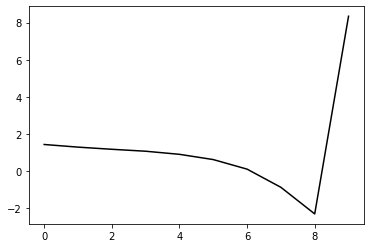

98000 0.23320926365702202
0.3205358944215782 -0.22363115551505497 0.2082438735997306 0.10361995710833577
[ 1.36934146  1.41508545  1.36935176  1.23284638  1.03355561  0.72680588
  0.19559065 -0.79316888 -2.23213773  8.30350485]


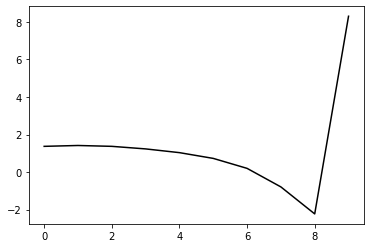

99000 0.1716260259387307
0.31774038660966536 -0.22325004002021878 0.20994712460063109 0.09769592682187442
[ 1.38656237  1.3023166   1.22651119  1.10932103  0.92708237  0.62728205
  0.09929377 -0.87415473 -2.27957097  8.26427622]


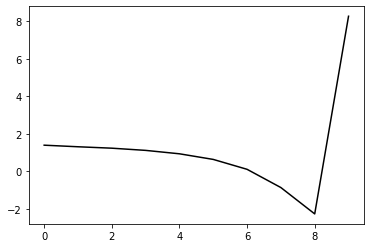

In [17]:
optimizer=tf.optimizers.Adam(learning_rate=0.0005)
for j in range (10000):    
    with tf.GradientTape() as g:
        loss=Error_func(h, m2, lam, alpha, beta, Positive[j%set], Negative[j%set])
        gradients=g.gradient(loss, [h, m2, lam, alpha, beta])
        if np.isnan(loss)==True: break
    for i in range (90):
        optimizer.apply_gradients(zip(gradients, [h]))
        if any(np.isnan(h.numpy()))==True: break
    for i in range (10):
        optimizer.apply_gradients(zip(gradients, [h, m2, lam, alpha, beta]))
        if any(np.isnan(h.numpy()))==True: break
    if j%100==0: 
        print(j*10, Error_func(h, m2, lam, alpha, beta, Positive[np.int32((j/set)%set)], Negative[np.int32((j/set)%set)]).numpy())
        print(m2.numpy(), lam.numpy(), alpha.numpy(), beta.numpy()), print(h.numpy())
        plt.plot(h.numpy(), 'k-'), plt.show()
    if j%1000==0:
        for i in range (set):
            [Positive0[i], Positive1[i]]=NN_func_01(h, m2, lam, alpha, beta, Positive[i])
            [Negative0[i], Negative1[i]]=NN_func_01(h, m2, lam, alpha, beta, Negative[i])
        for i in range (set):
            x_data1[i]=[v[0] for v in Positive0[i]]
            y_data1[i]=[v[1] for v in Positive0[i]]
            x_data2[i]=[v[0] for v in Positive1[i]]
            y_data2[i]=[v[1] for v in Positive1[i]]
            x_data3[i]=[v[0] for v in Negative0[i]]
            y_data3[i]=[v[1] for v in Negative0[i]]
            x_data4[i]=[v[0] for v in Negative1[i]]
            y_data4[i]=[v[1] for v in Negative1[i]]
            plt.plot(x_data4[i], y_data4[i], 'g.')
            plt.plot(x_data2[i], y_data2[i], 'c.')
            plt.plot(x_data1[i], y_data1[i], 'r.')
            plt.plot(x_data3[i], y_data3[i], 'm.')
        plt.show()

0 0.38447290680023494
0.32426527860210136 -0.2110261152044108 0.2175858790441069 0.092880162564678
[ 1.33802126  1.3933543   1.3137008   1.18651697  0.99595416  0.68924334
  0.15646777 -0.81649327 -2.20571127  8.35363972]


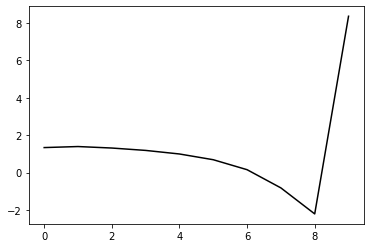

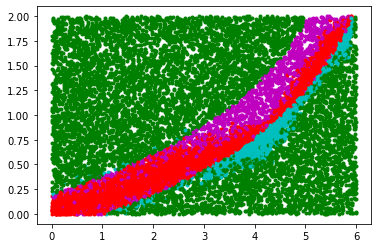

1000 0.1946577163004953
0.315166385574052 -0.21307045025016788 0.21617361525892223 0.11105758558177503
[ 1.3273131   1.32776524  1.2692628   1.12349963  0.89413821  0.54951054
 -0.00938878 -0.99289284 -2.36952295  8.29540258]


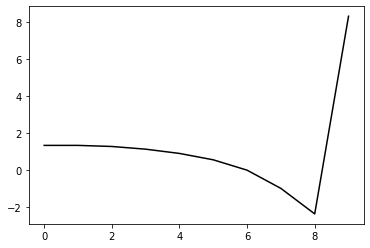

2000 0.19618850708039293
0.31229322607849513 -0.2106811600990496 0.21733048098745958 0.11045759609258093
[ 1.33201988  1.28291084  1.19392173  1.0820064   0.90633044  0.60225781
  0.06381259 -0.90253482 -2.2508435   8.31817678]


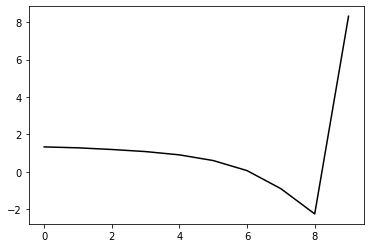

3000 0.13089635724670626
0.31829898583467275 -0.20158893602477027 0.21452870332828425 0.10716171981832182
[ 1.33386283  1.3113442   1.26007881  1.12633964  0.91638093  0.59591419
  0.05370492 -0.91694391 -2.25772841  8.31495407]


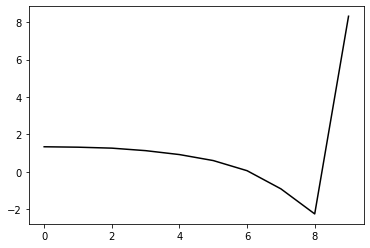

4000 0.19611502747385087
0.3042850077320624 -0.21343351550263773 0.22100313015383202 0.1092249899257484
[ 1.35484851e+00  1.21346085e+00  1.15945625e+00  1.05018671e+00
  8.57048916e-01  5.37422910e-01 -3.90942403e-03 -9.63818373e-01
 -2.27363064e+00  8.32792543e+00]


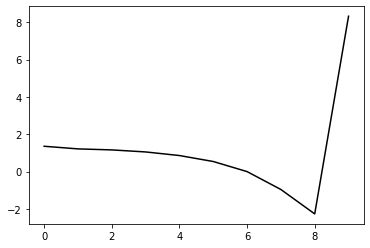

5000 0.18946056940724762
0.3042704022764695 -0.20839866950506966 0.21898090486382005 0.11095510797719603
[ 1.3286826   1.27026423  1.20186761  1.08600095  0.8913142   0.56624834
  0.00992697 -0.96678332 -2.28370071  8.31408799]


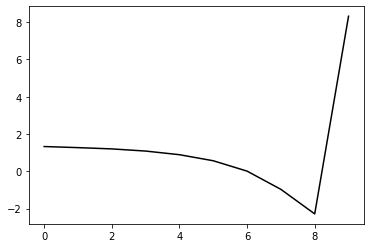

6000 0.1864979906890616
0.30418061073953784 -0.2021814954431487 0.21583712650875353 0.11409633575007228
[ 1.33397958  1.31871581  1.2564251   1.14836073  0.96967936  0.66378138
  0.12230588 -0.84513622 -2.14154847  8.32754424]


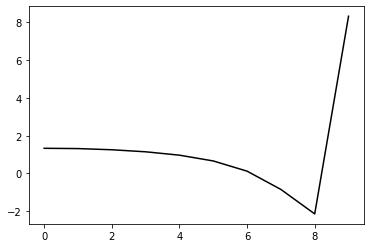

7000 0.2889430024250279
0.2967619446671588 -0.20489812636880128 0.2178856164098489 0.11386697127226528
[ 1.29016944  1.26782887  1.20342026  1.08427649  0.89718879  0.59539516
  0.06428123 -0.89683477 -2.18196529  8.3176533 ]


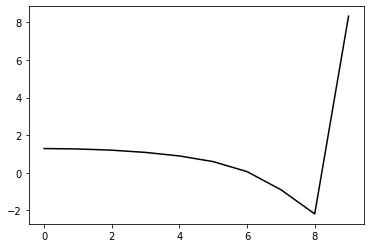

8000 0.31014348316510704
0.299083394183594 -0.20152663386557246 0.2202039260664812 0.11010321435465287
[ 1.26231409  1.32206979  1.26679953  1.13331676  0.94164954  0.6404094
  0.11196889 -0.85041148 -2.14192926  8.3498251 ]


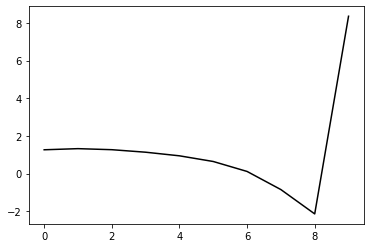

9000 0.18141172512836068
0.2947535332451025 -0.19564607616384586 0.21660807808738644 0.11064465721340208
[ 1.31968851  1.26706082  1.23265037  1.12544745  0.93474073  0.62218603
  0.08831393 -0.87213953 -2.15689315  8.34223679]


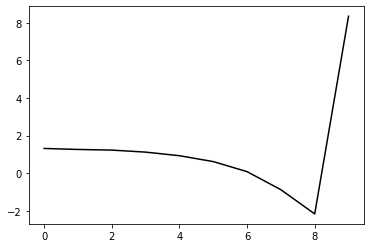

10000 0.17370914131818055
0.2952725005687638 -0.19391583585148403 0.21778531809389884 0.1092939684349307
[ 1.29170188  1.30043063  1.24492158  1.11834689  0.92033679  0.60844933
  0.07529205 -0.87842683 -2.14840686  8.33533112]


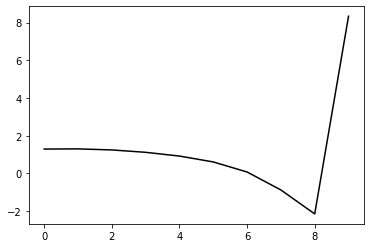

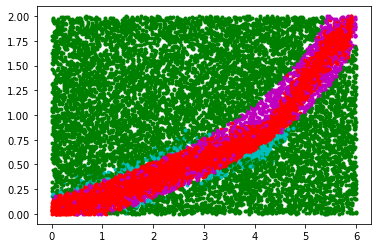

11000 0.28774282889562613
0.29233832096589263 -0.20108655593777144 0.22280978975944657 0.10818181368785165
[ 1.29536591  1.19056762  1.10889197  0.9827758   0.77873677  0.4561759
 -0.0809653  -1.02560252 -2.26762385  8.27702549]


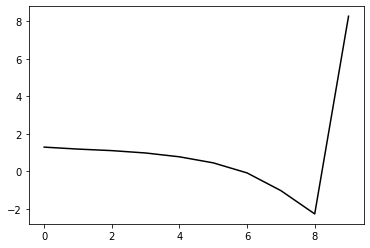

12000 0.1660724225277594
0.2928250686018987 -0.19608491787263055 0.2213442474136174 0.10889114926551645
[ 1.28872961  1.21912155  1.15237321  1.02379204  0.81883115  0.49232116
 -0.05612428 -1.0115238  -2.25801122  8.29333801]


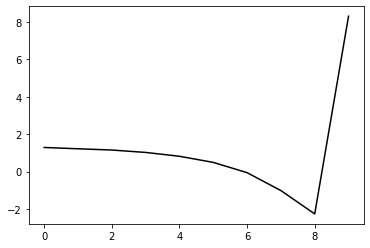

13000 0.20656175872485705
0.2870035149378603 -0.19738944332362163 0.22303755026153446 0.11230883955183814
[ 1.31955163  1.32015092  1.24364152  1.12561007  0.94602131  0.64716821
  0.11880581 -0.82361654 -2.05349606  8.35639619]


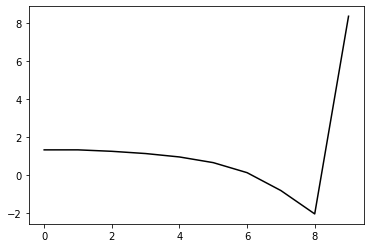

14000 0.23135420668051457
0.28847957209511305 -0.19131240692017606 0.22140951986859336 0.10981894669138356
[ 1.27213072  1.29569829  1.23661164  1.1284078   0.95069055  0.65028649
  0.12207172 -0.82463401 -2.05891425  8.3375104 ]


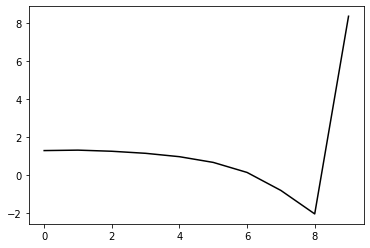

15000 0.18713507108675181
0.2825567895745006 -0.19405535628586545 0.2221576813216909 0.11230535200989342
[ 1.30220527  1.27850643  1.21065408  1.09474038  0.91033223  0.60850776
  0.08222717 -0.86102473 -2.08432444  8.32379646]


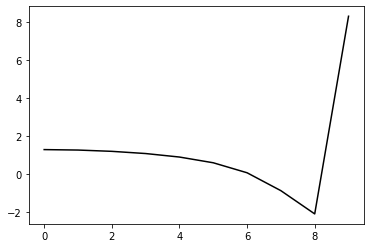

16000 0.15114395695309277
0.28919459427588595 -0.18759782382381776 0.22052425592721106 0.10823562203514177
[ 1.26534786e+00  1.26947785e+00  1.21202053e+00  1.07077887e+00
  8.56328740e-01  5.33635586e-01 -6.72927579e-03 -9.60376267e-01
 -2.18926075e+00  8.31274401e+00]


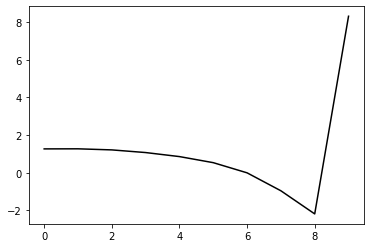

17000 0.17247090371392387
0.2829215771046863 -0.18729845817910806 0.22103058298779535 0.10956661469332565
[ 1.28817824  1.21437196  1.14641681  1.01480764  0.80871427  0.48352197
 -0.06051914 -1.01399542 -2.23714454  8.33112949]


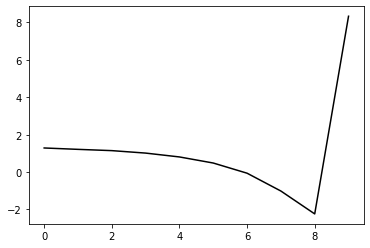

18000 0.2001098201332244
0.2819425468613854 -0.19314840180967233 0.22531286082903434 0.11355904396381687
[ 1.29466313  1.2812785   1.20207292  1.07396259  0.8799365   0.56445559
  0.02677754 -0.91355504 -2.1103535   8.28741758]


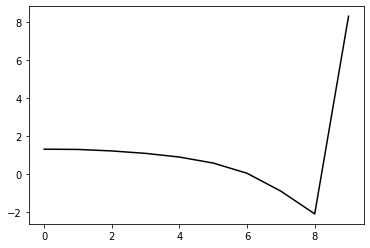

19000 0.11833983565013421
0.28429116843675767 -0.18432008345093548 0.22270679698621418 0.11018160938819187
[ 1.30175039  1.28318942  1.20888139  1.08499427  0.89624109  0.58907219
  0.05587385 -0.8888267  -2.09599295  8.34329784]


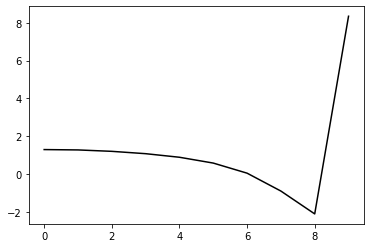

20000 0.17628392900040696
0.28561169401322917 -0.18216237505222627 0.22111559117497392 0.11627417771805766
[ 1.30325101  1.32253537  1.27063381  1.13376048  0.92556318  0.60257007
  0.06329085 -0.87869508 -2.07160769  8.335301  ]


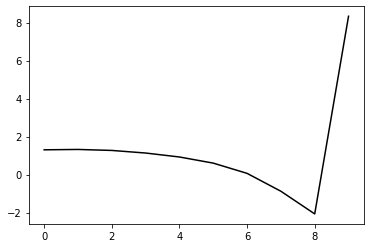

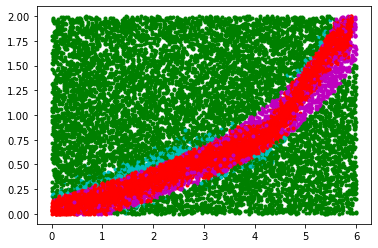

21000 0.1909258215373394
0.2841184038728466 -0.18379316323640882 0.22391169116996867 0.11498455172643143
[ 1.28270358  1.32336571  1.27270721  1.14597575  0.93877401  0.60525301
  0.05044382 -0.90589768 -2.11130998  8.30203955]


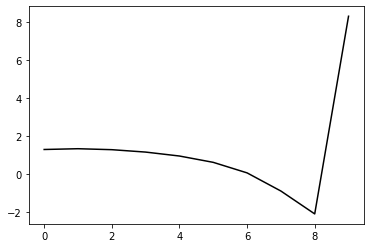

22000 0.25399366721979394
0.27772634065708535 -0.1827513159069896 0.22155952366085996 0.12066228074186788
[ 1.30711004  1.1853208   1.12224403  0.9967134   0.78854913  0.45162962
 -0.10976667 -1.06803959 -2.2625403   8.31609043]


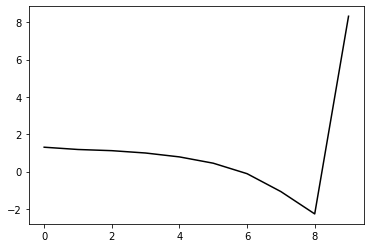

23000 0.15795206070526313
0.278102334587548 -0.18329348621038047 0.22449894578532817 0.11496891906741008
[ 1.28830015  1.23155713  1.16346765  1.04148227  0.84498136  0.52165981
 -0.03294003 -0.9959608  -2.20060655  8.34680534]


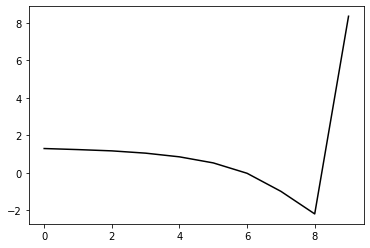

24000 0.18648418087491805
0.27849699974775866 -0.18115260639393188 0.22385923929684226 0.11464872551726375
[ 1.28159421  1.31246943  1.2571813   1.12202523  0.91799791  0.59307159
  0.03794505 -0.93097056 -2.14344758  8.32664595]


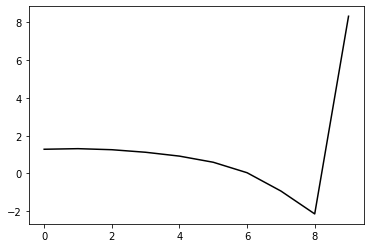

25000 0.2240794294111917
0.2772279288693326 -0.1787998706644848 0.22429369473784475 0.11222797148765723
[ 1.29646439  1.29102272  1.22887171  1.09587963  0.90201319  0.59726521
  0.06329294 -0.89080221 -2.09248135  8.34789237]


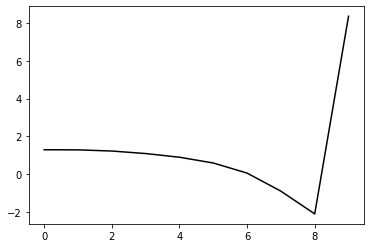

26000 0.2160207953139993
0.27140903884379564 -0.1870950908687923 0.23055874791062023 0.10944938211399478
[ 1.27669181  1.17108585  1.09014117  0.9547458   0.74675236  0.42519727
 -0.10811098 -1.04954634 -2.23182724  8.29490062]


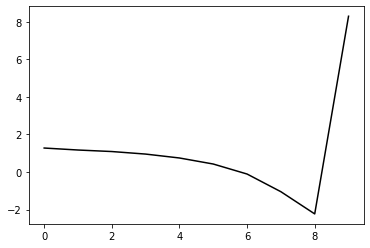

27000 0.20757311105303586
0.26916432823870373 -0.18197031037756842 0.22771468817225557 0.11304998481525483
[ 1.30510857  1.23267194  1.14598112  1.03018896  0.83497409  0.50952204
 -0.03827033 -0.99083272 -2.18503917  8.31101064]


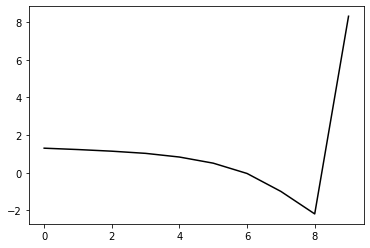

28000 0.20631929661112205
0.27000401352572717 -0.18155949746119807 0.22867781018664787 0.11377605801689449
[ 1.27847677  1.25060772  1.18377697  1.07738597  0.90179421  0.59609961
  0.05732954 -0.88813075 -2.06819816  8.33124025]


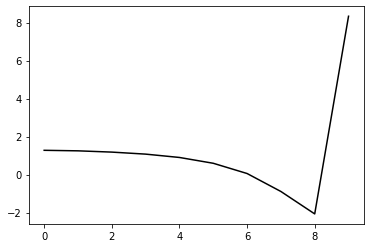

29000 0.24574957356038096
0.2696529275751356 -0.17861895321199256 0.22927103567013693 0.11052431482751822
[ 1.25275156  1.27758022  1.23093306  1.11764284  0.92682369  0.62087239
  0.09015461 -0.85734935 -2.05008326  8.39603079]


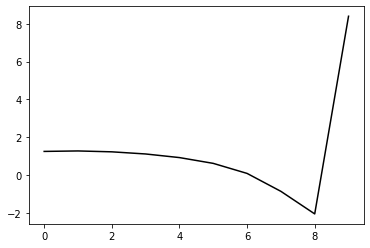

30000 0.25993753145853477
0.26707912376636744 -0.1759155770723974 0.22771920631747994 0.11357158288686467
[ 1.33140602  1.3200199   1.25556068  1.13767782  0.950924    0.64735128
  0.12395211 -0.8104975  -1.98716818  8.35853308]


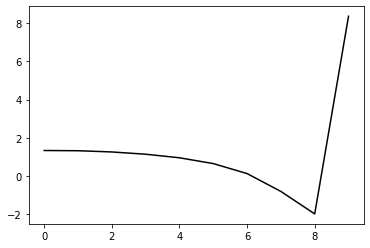

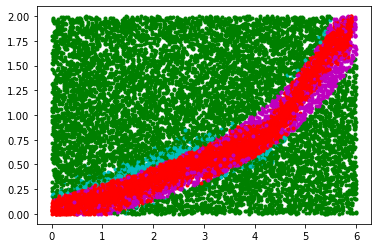

31000 0.2222392403959468
0.2648081021347088 -0.17978460261421778 0.23083480101577478 0.11167498349179214
[ 1.28199648e+00  1.23739756e+00  1.14607506e+00  1.01550539e+00
  8.23298090e-01  5.21507305e-01  3.34010801e-03 -9.21068029e-01
 -2.08549241e+00  8.32796293e+00]


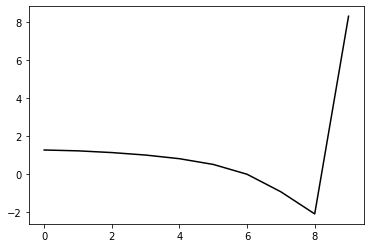

32000 0.20103659963124784
0.26727252138884666 -0.17209349128135418 0.22718865030978672 0.11032000436250909
[ 1.29483888  1.24144976  1.17816369  1.04884312  0.84180786  0.51907411
 -0.01824744 -0.95789568 -2.13899224  8.34879409]


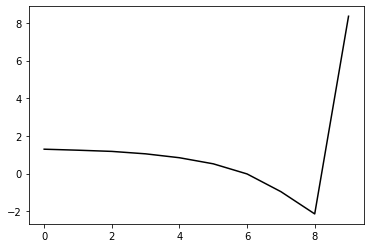

33000 0.17172550056563987
0.2649537713781887 -0.17579847024308407 0.22987184936543195 0.1125030241137016
[ 1.28387119e+00  1.27714403e+00  1.20298810e+00  1.06118697e+00
  8.53494075e-01  5.31182762e-01 -7.95927640e-03 -9.43892272e-01
 -2.11327832e+00  8.33065847e+00]


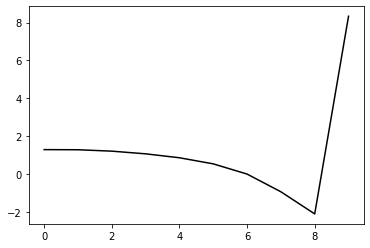

34000 0.1816392761522266
0.2595016664420976 -0.17677106817936675 0.2306704881596575 0.11405368614297855
[ 1.31868888  1.25023256  1.17946325  1.06137587  0.87026655  0.55738407
  0.02580392 -0.89945312 -2.05009421  8.33034466]


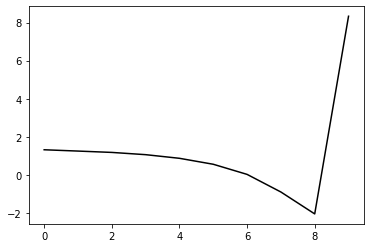

35000 0.21034514763816264
0.2677069897533712 -0.16888809912879427 0.22862494165009056 0.10871785505447824
[ 1.28941525  1.2845866   1.24170962  1.12817269  0.93157119  0.60745751
  0.05915878 -0.88670314 -2.05870615  8.3422437 ]


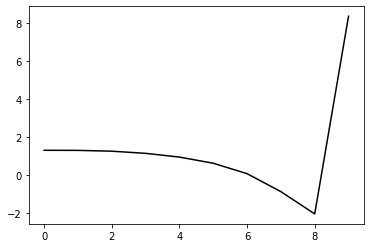

36000 0.27650724679482974
0.2664336714212935 -0.1778953331065519 0.23517015527272273 0.10512285372593946
[ 1.31443756  1.17033098  1.10046806  0.98283046  0.79256942  0.47517924
 -0.06743809 -1.0033183  -2.14877491  8.30327614]


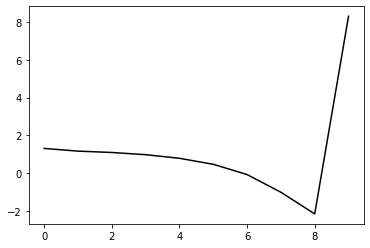

37000 0.2703460434448497
0.26462987384575404 -0.1732970530496039 0.23013793588648296 0.11291056186622647
[ 1.32942563  1.23864926  1.16855269  1.04950475  0.85366383  0.53361439
 -0.01041893 -0.94668733 -2.08295353  8.33277447]


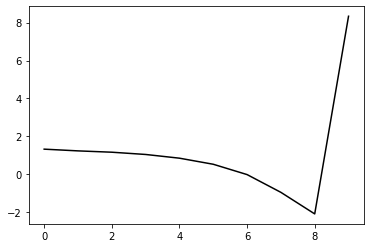

38000 0.18697263893962096
0.2684929256448852 -0.17141676931690347 0.23133592655343724 0.10981622013830082
[ 1.3026746   1.28904477  1.21688617  1.10274596  0.91278584  0.5921389
  0.0423247  -0.90471139 -2.05229518  8.31721795]


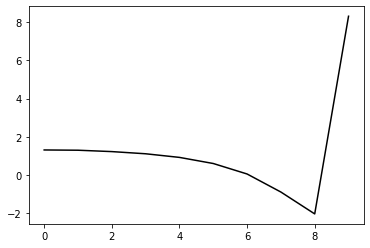

39000 0.16252925302906363
0.2740118994096687 -0.16624545679460662 0.22913815594824877 0.10954598137480712
[ 1.29670039  1.31446239  1.26465923  1.13390954  0.92142116  0.58877959
  0.03295997 -0.92180375 -2.07410014  8.32729252]


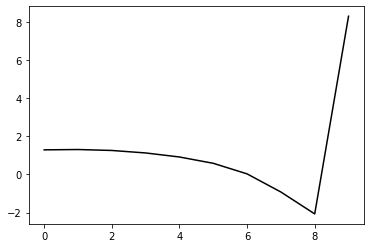

40000 0.2126352895904826
0.2739569059757548 -0.1668077738352067 0.2299391731234248 0.11076630447070224
[ 1.29247461  1.33066003  1.27462669  1.13927478  0.93195314  0.60841141
  0.06327802 -0.87766325 -2.00998473  8.35859639]


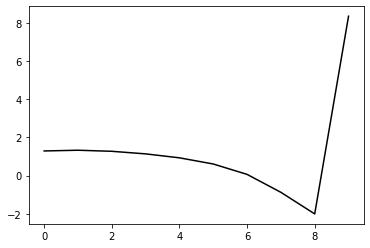

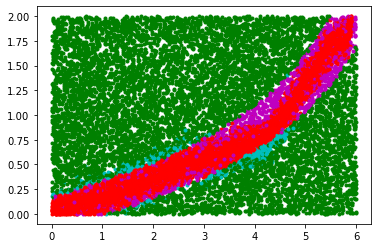

41000 0.1787009915842826
0.2797753576732623 -0.16313261589323363 0.22779230732397185 0.11472848338309084
[ 1.30428296e+00  1.36132301e+00  1.30062009e+00  1.13989180e+00
  9.09243929e-01  5.64872758e-01  6.49818587e-03 -9.39092891e-01
 -2.06841808e+00  8.35411204e+00]


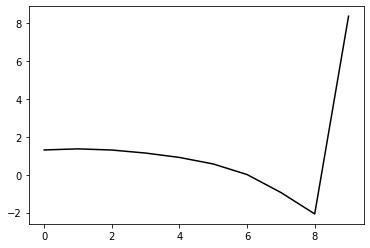

42000 0.2773387779429385
0.2734025601495855 -0.17412943279643958 0.23637530978684806 0.10964863503181738
[ 1.29017391  1.20349662  1.13369008  1.00454182  0.79510542  0.46223275
 -0.09094754 -1.03085759 -2.15111831  8.32449625]


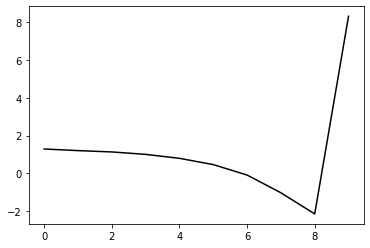

43000 0.1828192696528489
0.2752034259822567 -0.16593925131965845 0.2313069980534401 0.10945402205887667
[ 1.300694    1.24819755  1.16793811  1.03517324  0.82637021  0.48750725
 -0.07882879 -1.03634607 -2.17336472  8.32445786]


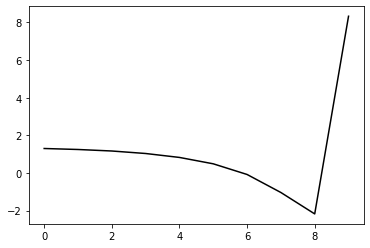

44000 0.2521899250492276
0.2736551648505423 -0.17339068059428261 0.2355701143726678 0.10961995620399188
[ 1.32274205  1.14803025  1.08352769  0.96731475  0.76973996  0.43972919
 -0.1164776  -1.05869467 -2.16384142  8.3141469 ]


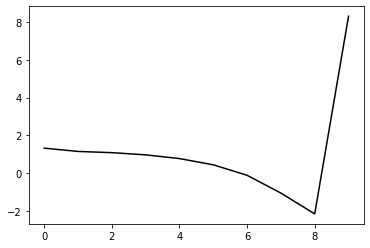

45000 0.23600845743885177
0.2682904828802368 -0.17463559764077521 0.2367175715099828 0.11230612352994876
[ 1.30713148  1.19910093  1.11962748  0.9800212   0.77836088  0.45630646
 -0.09496414 -1.04017146 -2.1508697   8.31653704]


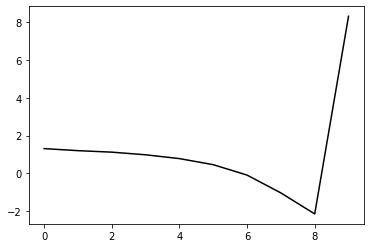

46000 0.3076503501477701
0.275468558296407 -0.16593217111455097 0.23457067773898838 0.1093282942574459
[ 1.24622425  1.24799466  1.17811026  1.0499937   0.84830216  0.5221593
 -0.03368764 -0.99080597 -2.12113433  8.32882647]


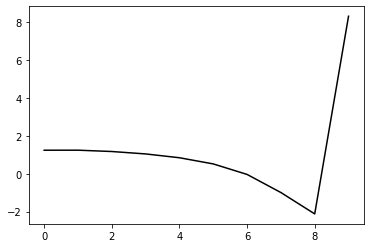

47000 0.23832526424886424
0.26784158042302547 -0.16933269851578311 0.23367695646845354 0.11906205174462152
[ 1.32267483  1.2880382   1.22262968  1.0789548   0.86579599  0.53146501
 -0.02792032 -0.98296526 -2.10287945  8.32857191]


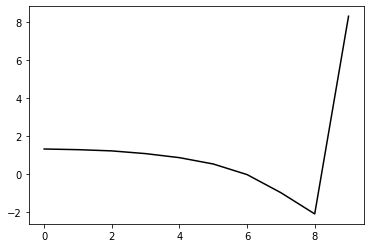

48000 0.22257784746633605
0.2761891422302705 -0.15851838436602816 0.23028643245539465 0.11368964529105968
[ 1.29901069  1.31243856  1.26173509  1.1450143   0.94049169  0.60330881
  0.03523938 -0.93345046 -2.07512027  8.35698008]


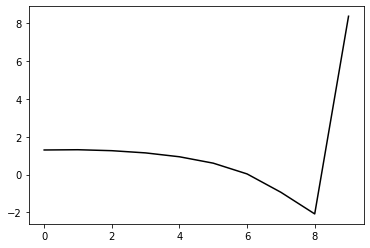

49000 0.15736625832603893
0.2753558960300359 -0.16318078344622625 0.23254147102550335 0.11317192648493582
[ 1.26762617  1.28734001  1.2188572   1.07811572  0.85909639  0.51602822
 -0.05741058 -1.03071762 -2.17191101  8.32927627]


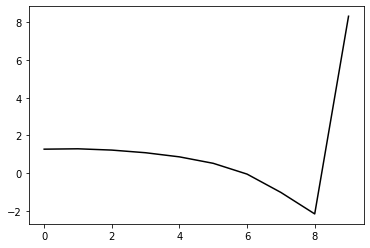

50000 0.220035877141852
0.2744303367570439 -0.16117725702038735 0.23235110591119396 0.11248447759518042
[ 1.24048614  1.27362157  1.18349739  1.04553781  0.84524237  0.5251801
 -0.02768143 -0.98892792 -2.12623255  8.34066473]


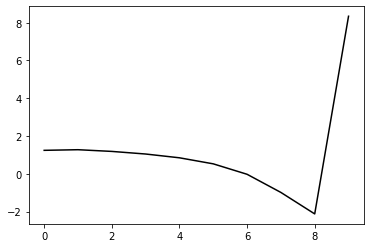

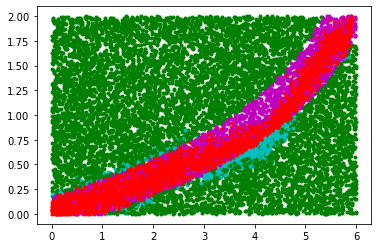

51000 0.1675353933805003
0.26895821191138874 -0.16461668614684793 0.2326177099269246 0.11726817257097266
[ 1.25984315  1.24700313  1.17803703  1.0236696   0.79242064  0.44588922
 -0.11884698 -1.08343178 -2.22072306  8.33509994]


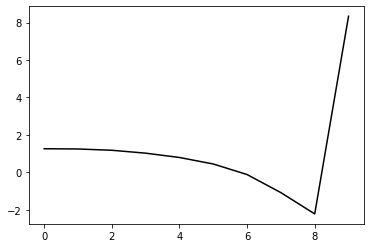

52000 0.19750269783676244
0.25906250061497166 -0.16535132898817717 0.23019370908390627 0.12215592299706558
[ 1.3140839   1.09806016  1.02497304  0.91268625  0.71646904  0.38578374
 -0.17315619 -1.12814418 -2.25626559  8.31888274]


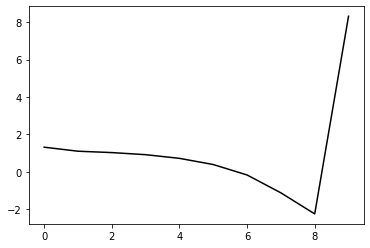

53000 0.23851027008434245
0.26148478982962575 -0.16937233636506996 0.23611490405506264 0.11674126974709904
[ 1.27478797  1.2100867   1.12070266  1.00138793  0.81248412  0.49958394
 -0.0425851  -0.98895592 -2.11559923  8.33497611]


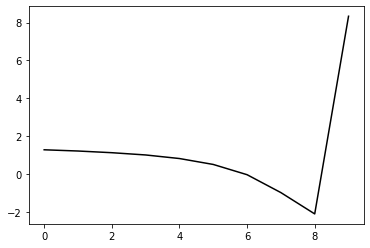

54000 0.1714458488698258
0.26406000676020286 -0.16503094124543424 0.2343015999542571 0.11812612438171481
[ 1.29683608  1.29836409  1.23764503  1.11381125  0.91686732  0.60111456
  0.06069407 -0.88527849 -2.01776014  8.34299585]


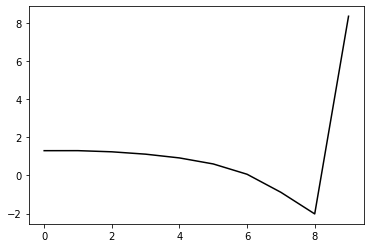

55000 0.14362977431995913
0.2625535271379693 -0.16075277619316367 0.2320287741524476 0.11590740479113766
[ 1.29875656  1.31251346  1.24775471  1.11434304  0.90747483  0.58258684
  0.03721847 -0.91320513 -2.05773211  8.35644571]


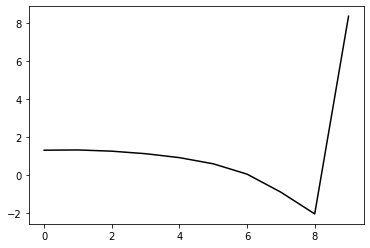

56000 0.14711385658875648
0.26516646019498175 -0.1609114598997053 0.23380731164151114 0.11390242804721873
[ 1.28379594  1.26696587  1.19923782  1.07541375  0.87097766  0.53902516
 -0.01463153 -0.96734595 -2.11255775  8.35383636]


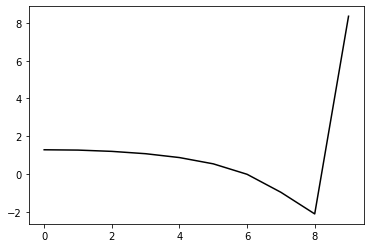

57000 0.23740200654258428
0.2656732569954741 -0.16080869123200764 0.23507521868181086 0.11074406678350451
[ 1.23030737  1.26370933  1.20938412  1.0877165   0.88606044  0.56209594
  0.01263433 -0.93736506 -2.08125768  8.34490549]


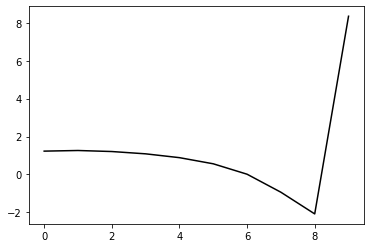

58000 0.22205529833742244
0.25244942212201704 -0.17073221538942238 0.23929486948089398 0.11470345022311763
[ 1.2850628   1.15111101  1.04581894  0.92673225  0.74115212  0.43135554
 -0.10388417 -1.03936634 -2.16591878  8.32564162]


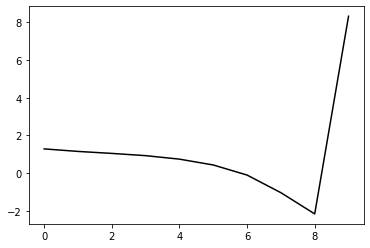

59000 0.17505855146379082
0.2621009645914892 -0.15871143096254836 0.23418900720387337 0.11406381947182591
[ 1.26661686  1.2475392   1.18705061  1.05885399  0.84684726  0.51545977
 -0.03895318 -0.99916899 -2.16245632  8.33343923]


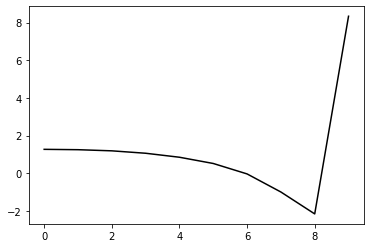

60000 0.2605415118202317
0.2601907775953008 -0.159396045769508 0.23315355487306066 0.11973689322109672
[ 1.26753499e+00  1.30171288e+00  1.24491510e+00  1.11090624e+00
  9.00584036e-01  5.61279534e-01 -3.83065042e-03 -9.68525976e-01
 -2.13115527e+00  8.30053870e+00]


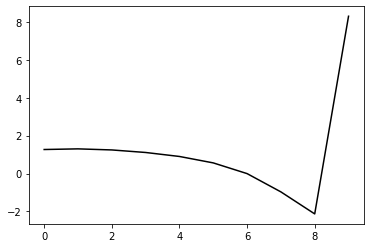

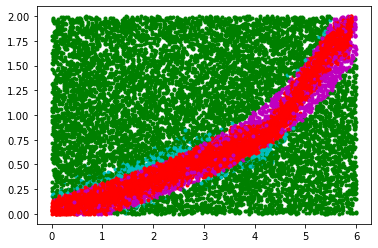

61000 0.18349747712192832
0.25837370662754305 -0.15965558251445888 0.23459576390514322 0.11555813583178924
[ 1.28110908  1.20452045  1.11671281  0.98688167  0.79811548  0.48386672
 -0.06748548 -1.02941231 -2.19771331  8.3276495 ]


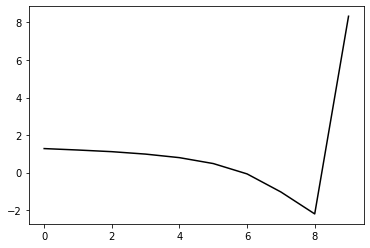

62000 0.15472435790212097
0.25915436585300616 -0.15633749515907594 0.23318917828363123 0.11607695148337728
[ 1.25155133  1.18664433  1.11974201  0.98959138  0.78724685  0.47045212
 -0.07108372 -1.02408398 -2.18500292  8.32951916]


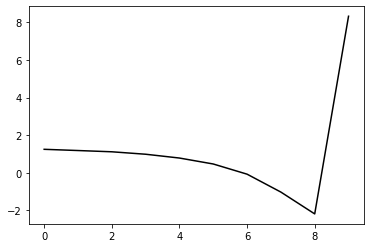

63000 0.1599702299542838
0.2589726858230459 -0.16231114662097892 0.23614581556423928 0.12071364484812397
[ 1.27881873  1.2427097   1.17596871  1.05056381  0.84478156  0.51984629
 -0.01908931 -0.95476083 -2.08658302  8.34164671]


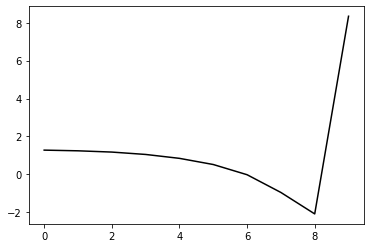

64000 0.22910673567558834
0.2633221700353365 -0.16076954242988586 0.23695773509189064 0.11755739987251944
[ 1.23639982  1.26630311  1.21529781  1.06843434  0.84214457  0.50533449
 -0.04475895 -0.98886557 -2.13031645  8.30170285]


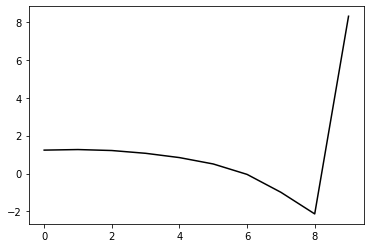

65000 0.19448199470389319
0.25953087175086054 -0.1584438963691388 0.23506657406813553 0.12166767044698612
[ 1.27583213  1.31287516  1.24196013  1.09061618  0.87723167  0.55297641
  0.01103035 -0.92221945 -2.04915478  8.32289908]


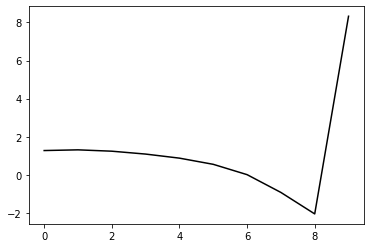

66000 0.19938529959445372
0.2639325601941351 -0.15613569103339703 0.23567780519509124 0.11664642159144761
[ 1.25342671  1.24493519  1.16964261  1.02986238  0.81501892  0.47988879
 -0.0726029  -1.01398043 -2.14711794  8.33944767]


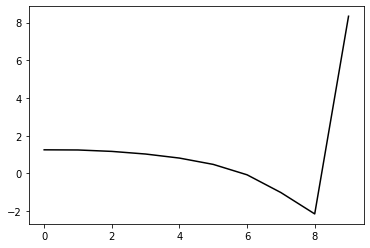

67000 0.2063563642945631
0.26116170838900116 -0.15969772039188043 0.2384416784285081 0.11584639480458638
[ 1.26641174  1.22638278  1.1348027   1.00015928  0.79523987  0.47301099
 -0.06855457 -1.00038083 -2.12186191  8.33061007]


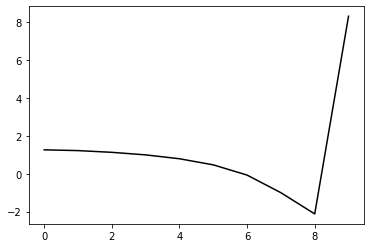

68000 0.18119352020382673
0.2610918636944707 -0.15595254808212844 0.23665610462174927 0.11391794603971303
[ 1.27392866  1.20155444  1.10391818  0.95650641  0.74783962  0.42509522
 -0.11640878 -1.05095867 -2.17685454  8.34020647]


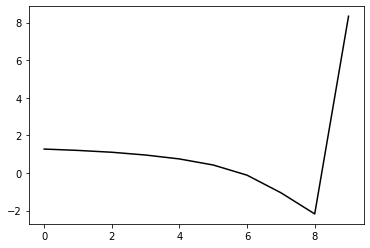

69000 0.12794208944648702
0.26418201562766963 -0.15441329373599477 0.23593805565337622 0.11322247523602115
[ 1.26782749  1.14964533  1.05292645  0.91061751  0.68890435  0.3520534
 -0.19332255 -1.12426912 -2.24099444  8.32423978]


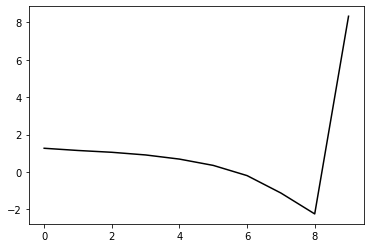

70000 0.18761648870737038
0.26653988056513334 -0.15280099049725104 0.23435149089278295 0.11769448304471809
[ 1.25575473  1.26066854  1.19546441  1.05738548  0.83239093  0.48349195
 -0.07554294 -1.00909206 -2.11513649  8.35284655]


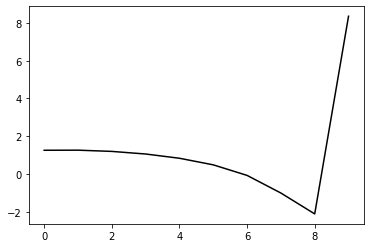

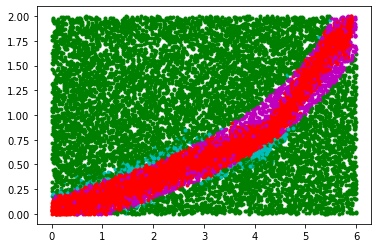

71000 0.22543697055082937
0.2592618592824912 -0.16020658515413458 0.2375386024554744 0.12101604931844293
[ 1.28683449  1.28375963  1.21957585  1.09979867  0.89934574  0.56550871
  0.00858841 -0.92367403 -2.01754795  8.35093216]


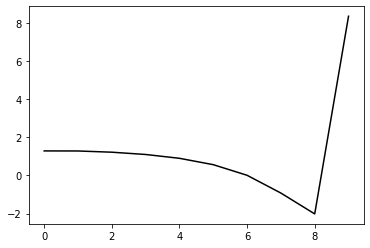

72000 0.1728164114923649
0.2627866913109047 -0.15848627000902274 0.2370771216106632 0.11970551864971085
[ 1.26106531  1.25412955  1.16691343  1.02506917  0.80772207  0.46545818
 -0.10255987 -1.05354363 -2.16406359  8.31670047]


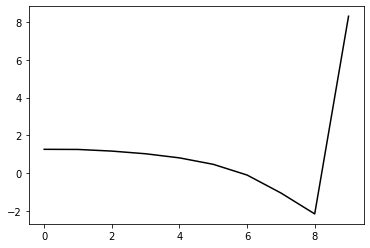

73000 0.1844051109708029
0.25874425121435374 -0.15875585670767894 0.23872425239437295 0.11658240015273291
[ 1.26912779  1.15720395  1.05000276  0.92252044  0.73139196  0.42131558
 -0.11721974 -1.04971292 -2.1458439   8.31627765]


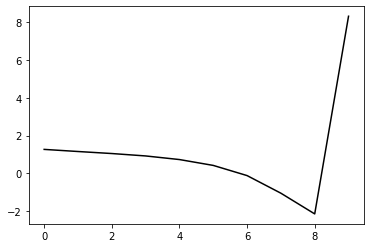

74000 0.22621775466229027
0.2601857805433928 -0.15720580946280566 0.2394912722713692 0.11618474709813693
[ 1.28503694  1.22390366  1.11998095  0.98198102  0.77889882  0.46713608
 -0.05848384 -0.97891799 -2.06779051  8.32127763]


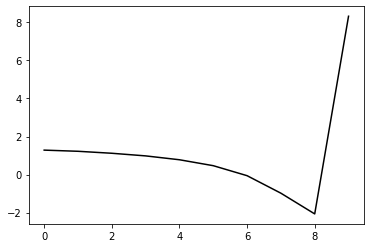

75000 0.13761484014509928
0.2593887439068409 -0.1591858081418121 0.24182408289200757 0.11194791943272994
[ 1.2723515   1.18147536  1.10077523  0.95801547  0.74396595  0.41767558
 -0.11692704 -1.0370529  -2.12849175  8.3087628 ]


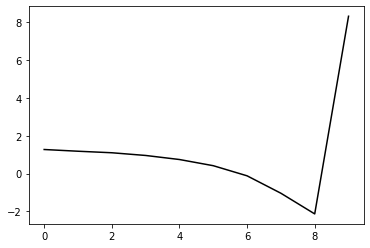

76000 0.21296730595806596
0.2583454236030364 -0.15860142490055465 0.2422146603589155 0.11029232127911033
[ 1.28816038  1.18721885  1.0904929   0.95116589  0.7509804   0.43917199
 -0.08385463 -0.98985874 -2.06774078  8.31149745]


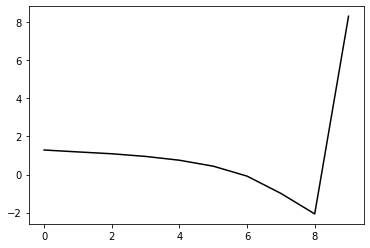

77000 0.26573180102050725
0.26114198070952815 -0.15239795104137122 0.23689321596519264 0.11540018131150628
[ 1.28411882  1.28030574  1.22110156  1.09762691  0.89252832  0.56222962
  0.02235893 -0.88828791 -1.95747827  8.35165288]


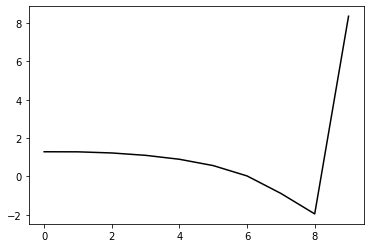

78000 0.30961115268927725
0.2596692302044425 -0.1534354804722739 0.23768081055811086 0.11431570122233287
[ 1.27161382  1.24347892  1.15893807  1.00120475  0.77701093  0.44707386
 -0.09105459 -0.9981793  -2.05500317  8.32670933]


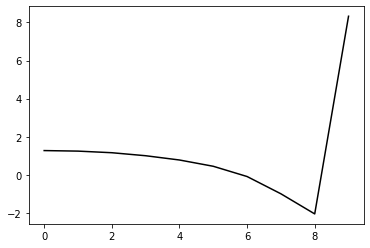

79000 0.2574715037946601
0.2569305222213582 -0.1529788304108257 0.23755645330258918 0.11239113599582608
[ 1.29660814  1.24346202  1.18360071  1.0413254   0.81635939  0.47691625
 -0.06789991 -0.9794357  -2.03749548  8.37743529]


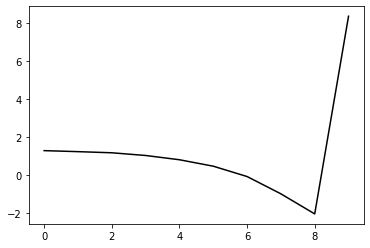

80000 0.23177730777975752
0.2528994809437036 -0.15811270585357662 0.23984421454277052 0.11550698983061698
[ 1.28570592  1.2663386   1.18697691  1.05725572  0.85003114  0.51082446
 -0.04545374 -0.96567753 -2.0222433   8.33632921]


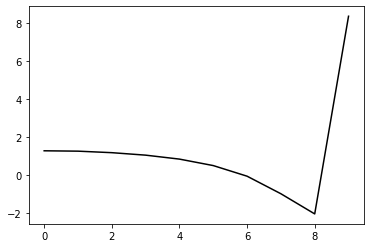

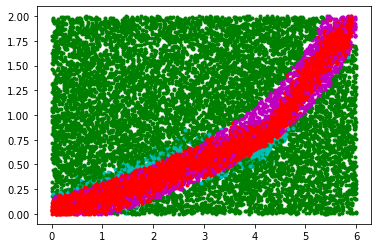

81000 0.1957268638271589
0.2558822605725052 -0.159210857335254 0.24128032035170688 0.11171450531028962
[ 1.28366432  1.20066841  1.12985511  0.99594856  0.77940279  0.42763528
 -0.15240141 -1.10352591 -2.18534412  8.29596014]


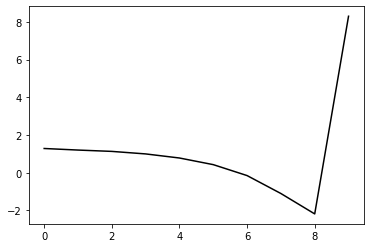

82000 0.2586474260604405
0.2567579077975224 -0.15866731944738127 0.24142085215777268 0.10953549140838181
[ 1.28800072  1.22463455  1.16119924  1.03466022  0.82691682  0.48562321
 -0.0908507  -1.04973168 -2.13764083  8.29300451]


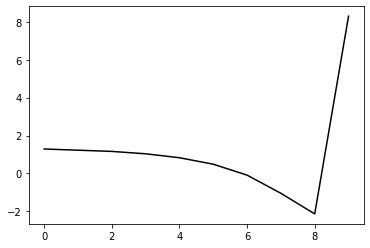

83000 0.1165902723838117
0.2563896884167217 -0.1536815163918454 0.23778617924821513 0.11400540849795704
[ 1.30445626  1.25914774  1.19497195  1.06722387  0.86389608  0.53565494
 -0.02837896 -0.98674329 -2.07798065  8.3133661 ]


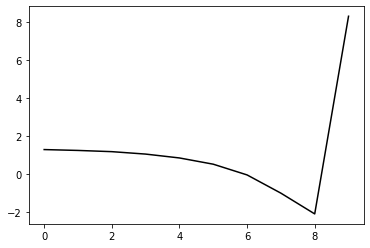

84000 0.31856509569343044
0.26344069542935794 -0.15670827592712192 0.241066257359206 0.11359967667261989
[ 1.23813194  1.28771821  1.22795087  1.10354497  0.89144494  0.54709161
 -0.02637804 -0.99393818 -2.09467556  8.37224168]


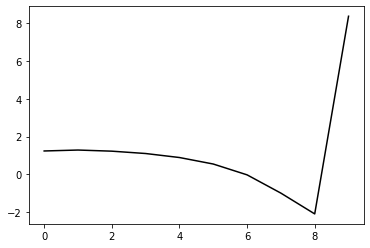

85000 0.19261635003235458
0.261908163489533 -0.15182826608151742 0.2367628733323461 0.11688132915514769
[ 1.23992743  1.24849214  1.19016788  1.06901493  0.86194016  0.51748894
 -0.06262137 -1.03754999 -2.1439108   8.36565066]


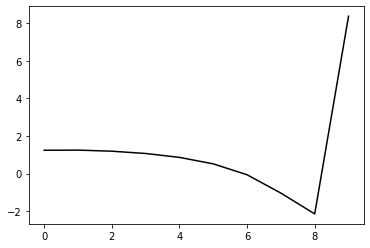

86000 0.15203271339685887
0.2561584635102898 -0.15401180443387996 0.23670979842663234 0.11874761341201513
[ 1.33796321  1.21088221  1.12301318  1.00106123  0.81395006  0.49668227
 -0.05786052 -1.01309418 -2.09966188  8.36206423]


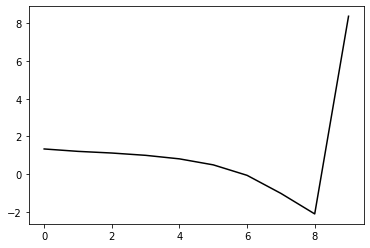

87000 0.18029776209311457
0.2588692175484859 -0.15261391018167283 0.2392324060499081 0.11294925982639856
[ 1.28419176  1.23388499  1.15437161  1.01619329  0.81641017  0.50419602
 -0.0346376  -0.98150418 -2.07598038  8.33776456]


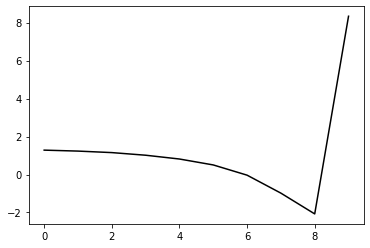

88000 0.25352602275133146
0.2596870128302496 -0.15057380893967132 0.2388794650573551 0.1124659002283227
[ 1.27863016  1.28346993  1.18634196  1.04379061  0.83573568  0.51465074
 -0.02035488 -0.95403346 -2.04514983  8.36360075]


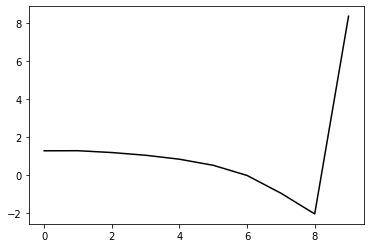

89000 0.23800693169099296
0.2588933601075938 -0.15196836679608525 0.23985927867889123 0.11234829862467441
[ 1.27369114  1.27571191  1.21453065  1.08135139  0.86568774  0.53150328
 -0.01377591 -0.94663619 -2.03764951  8.33449807]


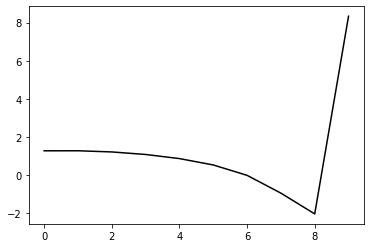

90000 0.29222231587660036
0.2506536753869925 -0.15283233668775048 0.23733321796667123 0.11652098298703004
[ 1.303397    1.19354191  1.12171054  0.9972628   0.78995937  0.44907235
 -0.11570267 -1.06382506 -2.16711959  8.33495328]


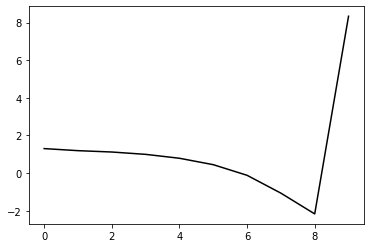

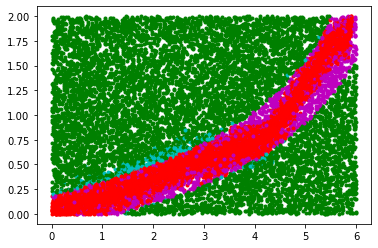

91000 0.2257002845253348
0.25552516340336023 -0.15187445198592162 0.23860760549920756 0.11472697494842066
[ 1.28069532e+00  1.27112358e+00  1.21993117e+00  1.09038504e+00
  8.86203624e-01  5.57173063e-01 -1.60556714e-03 -9.50340604e-01
 -2.05432335e+00  8.35410655e+00]


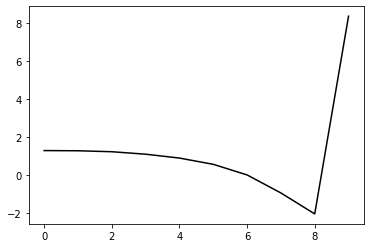

92000 0.229518330555575
0.2563974100576471 -0.15216915490529972 0.23943156681597821 0.11440970209156047
[ 1.262828    1.27193548  1.21232724  1.08611626  0.88650606  0.56167666
  0.00898666 -0.93689708 -2.03660914  8.33777931]


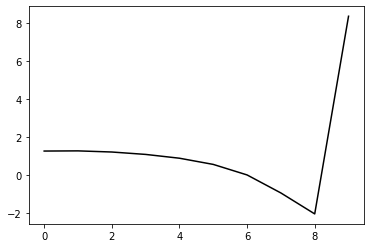

93000 0.15859329219284696
0.25960603164728296 -0.14815913663013294 0.23739487205635945 0.1168448100431169
[ 1.28469333  1.29562379  1.19973741  1.03267603  0.81752542  0.49229327
 -0.05713943 -1.00432206 -2.11047641  8.32751371]


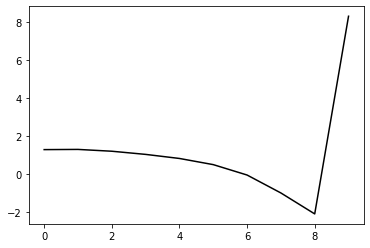

94000 0.2123201048269594
0.2534107786538293 -0.158741122162237 0.24467690375479573 0.1119905585706221
[ 1.295566    1.21522797  1.12281406  0.97722417  0.77669288  0.46298132
 -0.07032633 -1.00033235 -2.09552926  8.27498034]


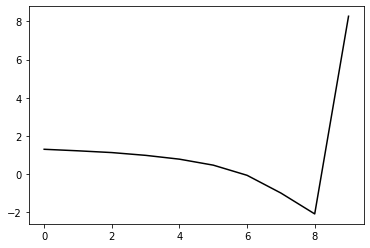

95000 0.14493824998163
0.25536371189241525 -0.15398655283711357 0.2408453713139278 0.1153526645393482
[ 1.26106643  1.30127534  1.21870272  1.08562631  0.88540833  0.56343065
  0.02168434 -0.91233178 -2.01303678  8.31216005]


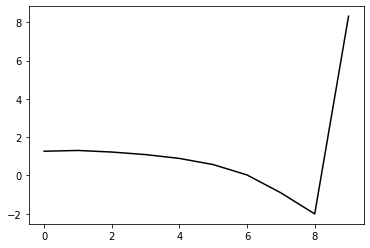

96000 0.20630477970638714
0.25289625860125514 -0.15912491848777005 0.24466750224204079 0.11366828173731333
[ 1.29706369  1.19749236  1.12541912  0.97715546  0.75727728  0.42516697
 -0.12360106 -1.06306645 -2.1697829   8.29647048]


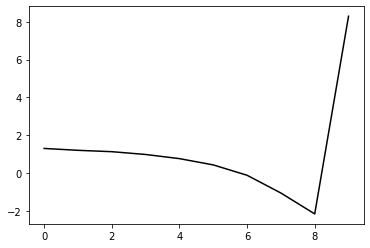

97000 0.18929367059508184
0.25736811462529263 -0.15820240601909327 0.24536326991051471 0.11030060749712381
[ 1.28543381  1.18526156  1.12193619  0.99197006  0.77802983  0.43680297
 -0.12491914 -1.07320524 -2.18617187  8.28863428]


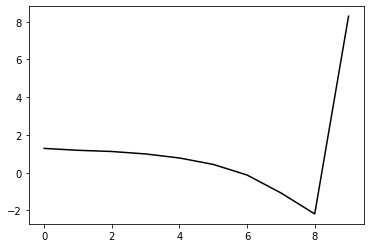

98000 0.27482422981473753
0.25911748893495945 -0.1524660370457203 0.24036601868496899 0.1156311992425504
[ 1.24967534  1.26040765  1.21111895  1.08999319  0.87394096  0.52086655
 -0.05794824 -1.01909793 -2.13551707  8.32192802]


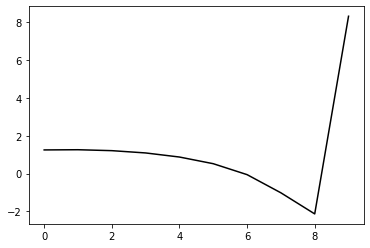

99000 0.16362259756628028
0.2535793584622889 -0.15186735600594586 0.24047458674421782 0.11670907402394194
[ 1.26026325  1.2515403   1.19238789  1.08159233  0.89470038  0.57837344
  0.02089054 -0.93730348 -2.05770187  8.35274217]


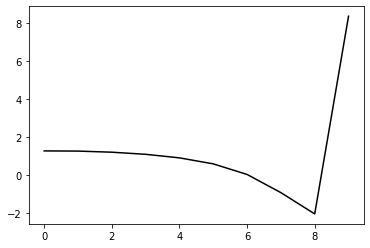

In [18]:
optimizer=tf.optimizers.Adam(learning_rate=0.0005)
for j in range (10000):    
    with tf.GradientTape() as g:
        loss=Error_func(h, m2, lam, alpha, beta, Positive[j%set], Negative[j%set])
        gradients=g.gradient(loss, [h, m2, lam, alpha, beta])
        if np.isnan(loss)==True: break
    for i in range (90):
        optimizer.apply_gradients(zip(gradients, [h]))
        if any(np.isnan(h.numpy()))==True: break
    for i in range (10):
        optimizer.apply_gradients(zip(gradients, [h, m2, lam, alpha, beta]))
        if any(np.isnan(h.numpy()))==True: break
    if j%100==0: 
        print(j*10, Error_func(h, m2, lam, alpha, beta, Positive[np.int32((j/set)%set)], Negative[np.int32((j/set)%set)]).numpy())
        print(m2.numpy(), lam.numpy(), alpha.numpy(), beta.numpy()), print(h.numpy())
        plt.plot(h.numpy(), 'k-'), plt.show()
    if j%1000==0:
        for i in range (set):
            [Positive0[i], Positive1[i]]=NN_func_01(h, m2, lam, alpha, beta, Positive[i])
            [Negative0[i], Negative1[i]]=NN_func_01(h, m2, lam, alpha, beta, Negative[i])
        for i in range (set):
            x_data1[i]=[v[0] for v in Positive0[i]]
            y_data1[i]=[v[1] for v in Positive0[i]]
            x_data2[i]=[v[0] for v in Positive1[i]]
            y_data2[i]=[v[1] for v in Positive1[i]]
            x_data3[i]=[v[0] for v in Negative0[i]]
            y_data3[i]=[v[1] for v in Negative0[i]]
            x_data4[i]=[v[0] for v in Negative1[i]]
            y_data4[i]=[v[1] for v in Negative1[i]]
            plt.plot(x_data4[i], y_data4[i], 'g.')
            plt.plot(x_data2[i], y_data2[i], 'c.')
            plt.plot(x_data1[i], y_data1[i], 'r.')
            plt.plot(x_data3[i], y_data3[i], 'm.')
        plt.show()

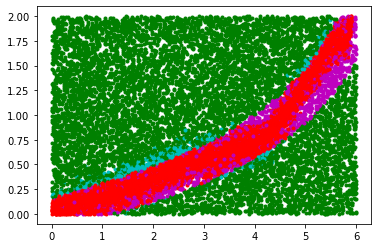

In [20]:
for i in range (set):
    [Positive0[i], Positive1[i]]=NN_func_01(h, m2, lam, alpha, beta, Positive[i])
    [Negative0[i], Negative1[i]]=NN_func_01(h, m2, lam, alpha, beta, Negative[i])
for i in range (set):
    x_data1[i]=[v[0] for v in Positive0[i]]
    y_data1[i]=[v[1] for v in Positive0[i]]
    x_data2[i]=[v[0] for v in Positive1[i]]
    y_data2[i]=[v[1] for v in Positive1[i]]
    x_data3[i]=[v[0] for v in Negative0[i]]
    y_data3[i]=[v[1] for v in Negative0[i]]
    x_data4[i]=[v[0] for v in Negative1[i]]
    y_data4[i]=[v[1] for v in Negative1[i]]
    plt.plot(x_data4[i], y_data4[i], 'g.')
    plt.plot(x_data2[i], y_data2[i], 'c.')
    plt.plot(x_data1[i], y_data1[i], 'r.')
    plt.plot(x_data3[i], y_data3[i], 'm.')
plt.show()

99990 0.1330039802187164
0.2508162645178172 -0.14861568717453852 0.23800323579688346 0.11793669887000827
[ 1.30239683  1.25208227  1.19768428  1.07699238  0.88045833  0.56685715
  0.02673624 -0.91924995 -2.03108357  8.35309264]


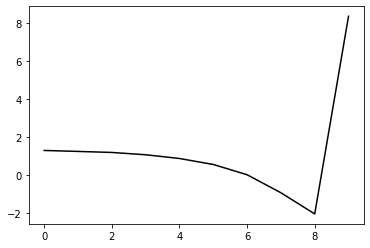

([<matplotlib.lines.Line2D at 0x1dcb5542908>], None)

In [19]:
print(j*10, Error_func(h, m2, lam, alpha, beta, Positive[np.int32((j/set)%set)], Negative[np.int32((j/set)%set)]).numpy())
print(m2.numpy(), lam.numpy(), alpha.numpy(), beta.numpy()), print(h.numpy())
plt.plot(h.numpy(), 'k-'), plt.show()